# NOTES
paper_rep
- Images 108 and 109 are the ones not used in validation and train. Therefore ony those images are used for the reporting.
- added reporting tools for acclusion
- added reporting tools for 3DUCM

V6 
- added Attention
V5 
- Replace Korolev'S dense with FN.

V4
- Deleted old heatmaps
- Added attention heatmap !!!! Not completed yet
- corrected the bug found in the  model. Check models5.pdf
- deleted precision

V3
- Rewrote the model using the code in gıthub
- Added parametric options to the build so that FN, Att can run on various modes of Aggregation and Global features


V2
the model modified so that g-global features are taken from the end FC (JetLey's)

V1
- Copied from AD_mainV2 to add attention to VoxCNN
- Model ResNet is deleted


# imports

In [2]:
import pandas as pd
import numpy as np
import nibabel as nib   #YT: neuroimaging libary in python
from tqdm import tqdm
import logging
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RepeatedStratifiedKFold
import time
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix
import sys
import os
from sklearn.model_selection import train_test_split
#import models           #YT .py file that defines the models
# YT .py file that creates the batches for training. I did not implemented as all data is already in the memory.
# Can be used again if batch generation needed for more larger datasets
#import utils  
import tensorflow as tf
from tensorflow import keras
from skimage.transform import rotate
from tensorflow.keras.utils import to_categorical

from functools import partial
from tensorflow.keras.layers import Input, Conv3D, Dense, MaxPool3D,BatchNormalization, Activation,  Concatenate, Dot
from tensorflow.keras.layers import Attention, AdditiveAttention, Reshape
from tensorflow.keras.layers import Add, Flatten, Lambda, Dropout, Permute,UpSampling3D, GlobalAveragePooling3D,Conv3DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.python.ops import math_ops

###############################
##         YT Added for FN 
#from Kfocusingtf2 import FocusedLayer1D
from Kfocusingtf2_YT2 import FocusedLayer1D
from keras_utils_tf2 import RecordVariable, RecordOutput, \
  PrintLayerVariableStats, SGDwithLR, eval_Kdict, standarize_image_025,\
  standarize_image_01, AdamwithClip, ClipCallback


from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)


if os.name=="nt" :
    os.environ['CUDA_VISIBLE_DEVICES']="0"  #YT 1 is CPU, 0 is GPU
else :
    os.environ['CUDA_VISIBLE_DEVICES']="0"
    
import copy   
from skimage.transform import resize
import shap
import glob

# Data path and file name definitions

In [3]:
outputpath = os.path.join(os.curdir, "results_att_V6")    #YT: Papers results dir. Not used so far. Kept for legacy
root_logdir = os.path.join(os.curdir, "my_logsv2")          #YT: Added for TensorBoard logs
datapath = os.path.join('..\\', "images")              #YT: Added for the images. 

#YT added for TensorBoard logs Time stamps not a good descriptive naming think of a better one!
def get_run_logdir(mod):
    import time
    run_id = time.strftime("%m_%d-%H_%M")
    run_id = mod["model"][0:3]+mod["dset1"]+mod["dset2"]+str(mod["batch_size"])+"_"+mod["sActivation"]+run_id
    return os.path.join(root_logdir, run_id)



# Load Data
    Parameters
    ----------
    first_class : {'AD', 'LMCI', 'EMCI', 'Normal'}
        String label for target == 0.
    second_class : {'AD', 'LMCI', 'EMCI', 'Normal'}
        String label for target == 1.
    results_folder : string
        Folder to store results.
    
    Returns
    -------
        nump : data     (tf.dataset: switched back to numpy as I had issues to implement "sparse categorical with this new dataset. Will look into that later)
        numpy: targets for given data classes.



In [4]:
#YT Papers origional code
def LoadData(first_class, second_class, results_folder):

    results_folder= os.path.join(outputpath,'ad_vs_norm')
    metadata_fname = os.path.join(datapath,'metadata.csv')

    if first_class not in {'AD', 'LMCI', 'EMCI', 'CN'}:
        msg = "First class must be 'AD', 'LMCI', 'EMCI' or 'Normal', not {0}"
        raise ValueError(msg.format(first_class))
    
    if second_class not in {'AD', 'LMCI', 'EMCI', 'CN'}:
        msg = "Second class must be 'AD', 'LMCI', 'EMCI' or 'Normal', not {0}"
        raise ValueError(msg.format(second_class))
        
    if first_class == second_class:
        raise ValueError("Class labels should be different")
        
    if not os.path.exists(results_folder):
        os.makedirs(results_folder)
        
    metadata = pd.read_csv(metadata_fname)
    smc_mask = ((metadata.Label == first_class) |
                (metadata.Label == second_class)).values.astype('bool')
    data = np.zeros((smc_mask.sum(), 1, 110, 110, 110), dtype='float32')
    target = (metadata[smc_mask].Label == second_class).values.astype('int32')
    for it, im in tqdm(enumerate(metadata[smc_mask].Path.values),
                      total=smc_mask.sum(), desc='Reading MRI to memory'):
        #print (im)
        mx = nib.load(os.path.join(datapath,im)).get_fdata().max(axis=0).max(axis=0).max(axis=0)
        data[it, 0, :, :, :] = np.array(nib.load(os.path.join(datapath,im)).get_fdata()) / mx

# YT: Last column of the tf dataset is class label. It has to be float 32 as well        
#    data = np.concatenate((data,target),axis=1)        
#    data_tf = tf.convert_to_tensor(data, np.float32)

    return data, target

# Load and Test data  

In [5]:
if (True) :
    data, target = LoadData("AD", "CN","ad_cn")
    print (data.shape, target.shape)
    print (target)

Reading MRI to memory: 100%|██████████| 112/112 [00:04<00:00, 23.75it/s]

(112, 1, 110, 110, 110) (112,)
[1 1 0 0 0 1 1 0 1 1 1 1 1 1 0 1 0 0 1 0 0 0 0 1 1 1 0 1 1 0 0 0 1 1 0 0 0
 1 1 0 1 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0 1 0 1 0 1 1 1
 1 1 0 1 1 1 1 0 0 1 1 1 1 1 0 1 0 0 1 1 0 1 1 0 1 0 0 0 0 0 0 0 1 1 1 1 1
 1]


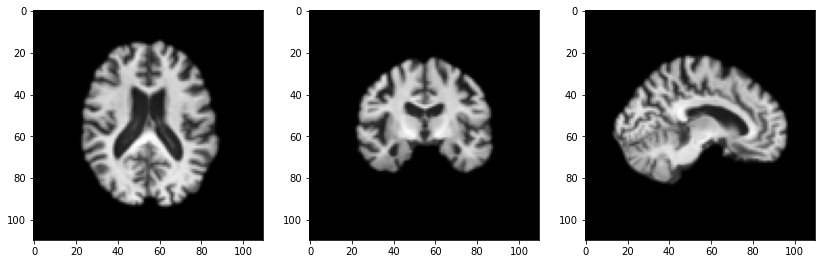

In [6]:
if (True) :
    nData = 111
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 3, 1)
    matr = rotate(data[nData,0,:,:, 60].reshape(110, 110), 90)
    plt.imshow(matr, cmap="gray")

    plt.subplot(1, 3, 2)
    matr = rotate(data[nData,0, :, 60, :].reshape(110, 110), 90)
    plt.imshow(matr, cmap="gray")


    plt.subplot(1, 3, 3)
    matr = rotate(data[nData,0,60, :, :].reshape(110, 110), 90)
    plt.imshow(matr, cmap="gray")
    #cbar = plt.colorbar()
    plt.show()  

# Preprocess data for training

From Paper: 
It is also important to note that because of the model size
and the limitations of GPU memory, we have to modify the
batch iteration process so that we are sure that there are samples
of each class in every batch.The balancing of the samples
inside each batch gives us more stable learning curves


In [7]:
#YT Papers origional code
def Balance_Data (X, y, shuffle=True) :
    
    indices = np.arange(len(X))

    if shuffle:
         np.random.shuffle(indices)
    m_len = np.min([sum(y == 1), sum(y == 0)])
    y = y[indices]
    pos = X[indices][np.where(y== 1)[0][:m_len]]
    neg = X[indices][np.where(y == 0)[0][:m_len]]
    pos_t = y[np.where(y == 1)[0][:m_len]]
    neg_t = y[np.where(y == 0)[0][:m_len]]

    X = np.insert(pos, np.arange(len(neg)), neg, axis=0)
    y = np.insert(pos_t, np.arange(len(neg_t)), neg_t, axis=0)
    
    return X,y


## VoxCNN

In [8]:

####YT  builds the VoxCNN model as defined in the paper
def Build_VoxCNN_Att (mod):

    tf.keras.backend.clear_session()
   
    input_shape = (1,110,110,110)   
    
    inputs = Input(input_shape, name='input')    #[bs,1,110,110,110]
    
    nn = Permute((2,3,4,1)) (inputs)             #[bs,110,110,110,1]

    sActivation = mod['sActivation'] 
    n_convs = [3, 3, 3, 2, 2]
     
    
    filters = [64, 128, 256, 512]  #YT future scale is 8 in Korolev's Paper 
    filters = [int(x / mod['feature_scale']) for x in filters]


    ####################
    # Feature Extraction

    nn = Conv3D (filters[0], kernel_size=3, strides=1, padding='same',activation =sActivation, name='cnv_1_'+str(filters[0])) (nn)    
    nn = Conv3D (filters[0], kernel_size=3, strides=1, padding='same',activation =sActivation,name='cnv_2_'+str(filters[0])) (nn)    
    nn = Conv3D (filters[0], kernel_size=3, strides=1, padding='same',activation ="linear",name='cnv_3_'+str(filters[0])) (nn) 
    conv1 = Activation(sActivation) (nn)
    if (mod['bBatchNorm_Cnv']):
        conv1 = BatchNormalization() (conv1)
    maxpool1 = MaxPool3D (pool_size=2, name='maxpool'+str(filters[0]))(conv1)

    nn = Conv3D (filters[1], kernel_size=3, strides=1, padding='same',activation =sActivation,name='cnv_1_'+str(filters[1])) (maxpool1)    
    nn = Conv3D (filters[1], kernel_size=3, strides=1, padding='same',activation =sActivation,name='cnv_2_'+str(filters[1])) (nn)    
    nn = Conv3D (filters[1], kernel_size=3, strides=1, padding='same',activation ="linear",name='cnv_3_'+str(filters[1])) (nn) 
    conv2 = Activation(sActivation) (nn)
    if (mod['bBatchNorm_Cnv']):
        conv2 = BatchNormalization() (conv2)
    maxpool2 = MaxPool3D (pool_size=2, name='maxpool'+str(filters[1]))(conv2)
   
    nn = Conv3D (filters[2], kernel_size=3, strides=1, padding='same',activation =sActivation,name='cnv_1_'+str(filters[2])) (maxpool2)    
    nn = Conv3D (filters[2], kernel_size=3, strides=1, padding='same',activation =sActivation,name='cnv_2_'+str(filters[2])) (nn)    
    nn = Conv3D (filters[2], kernel_size=3, strides=1, padding='same',activation ="linear",name='cnv_3_'+str(filters[2])) (nn) 
    conv3 = Activation(sActivation) (nn)
    if (mod['bBatchNorm_Cnv']):
        conv3 = BatchNormalization() (conv3)
    maxpool3 = MaxPool3D (pool_size=2, name='maxpool'+str(filters[2]))(conv3)

    nn = Conv3D (filters[3], kernel_size=3, strides=1, padding='same',activation =sActivation,name='cnv_1_'+str(filters[3])) (maxpool3)    
    nn = Conv3D (filters[3], kernel_size=3, strides=1, padding='same',activation =sActivation,name='cnv_2_'+str(filters[3])) (nn)    
    nn = Conv3D (filters[3], kernel_size=3, strides=1, padding='same',activation ="linear",name='cnv_3_'+str(filters[3])) (nn) 
    conv4 = Activation(sActivation) (nn) 
    if (mod['bBatchNorm_Cnv']):
        conv4 = BatchNormalization() (conv4)
    maxpool4 = MaxPool3D (pool_size=2, name='maxpool'+str(filters[3]))(conv4)
    
    nn = Conv3D (filters[3], kernel_size=3, strides=1, padding='same',activation =sActivation,name='cnv_g_1_'+str(filters[3])) (maxpool4) 
    nn = Conv3D (filters[3], kernel_size=3, strides=1, padding='same',activation ="linear",name='cnv_g_2_'+str(filters[3])) (nn) 
    conv5 = Activation(sActivation) (nn)
    
    
    
    ################
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    # Attention Maps  L1   DO NOT RUN MedIm, BUGGY FROM V3
    # compute compatibility score
      
    if  (mod['bL1']) :
        theta = conv4  #x  #YT does not need this for L1

#    theta = Conv3D(filters[3], kernel_size=1, strides=1, padding = 'valid', use_bias = False) (conv4) 
#    phi = Conv3D (filters[3],kernel_size=1, strides=1, padding = 'valid', use_bias = False) (conv5)    #g
        phi = conv5       
        phi_g = Conv3DTranspose (filters[3], kernel_size=3, strides=2, padding='valid', output_padding=None) (phi) #YT this is  used instead of upsampling
        f = Add()([theta, phi_g])
        f = Activation ('relu')(f)
        psi = Conv3D (1, kernel_size=1, strides=1, padding = 'valid', use_bias = True) (f)

        ############################################
        # normalisation -- scale compatibility score
        #sigm_psi_f = F.sigmoid(psi_f)
        sigm_psi_f = Activation ('sigmoid') (psi)
        att1 = sigm_psi_f * conv4     # the weighted average over the spatial axes is computed,

        att1_g = GlobalAveragePooling3D()(att1)

    
    ################
    # Attention Maps  L2
    # compute compatibility score
    if (mod['bL2']) :
        theta2 = Conv3D(filters[2], kernel_size=1, strides=1, padding = 'valid', use_bias = False) (maxpool3)   #x [bs,13,13,13,64]       
        phi2 = Conv3D (filters[2],kernel_size=1, strides=1, padding = 'valid', use_bias = False) (maxpool4)     #g [bs,6,6,6,64]                                   
    
   #     phi_g2 = Conv3DTranspose (filters[2], kernel_size=3, strides=2, padding='valid', output_padding=None) (phi2) 
        #YT this is  used instead of upsampling
        phi_g2 = Conv3DTranspose (filters[2], kernel_size=3, strides=2, padding='valid', output_padding=None) (phi2) #YT g [bs,13,13,13,64]
    
        f2 = Add()([theta2, phi_g2])
        f2 = Activation ('relu')(f2)

        psi2 = Conv3D (1, kernel_size=1, strides=1, padding = 'valid', use_bias = True) (f2) #[bs,13,13,13,1]
    
        ############################################
        # normalisation -- scale compatibility score
    
        sigm_psi_f2 = Activation ('sigmoid', name ='Sig_L2') (psi2)
        print(sigm_psi_f2)
        # the weighted average over the spatial axes is computed,
        att2 = sigm_psi_f2 * maxpool3 #[bs,13,13,13,64]    
        att2_g = GlobalAveragePooling3D()(att2)
    
    ############################
    ## Global Features
    ############################
    if (mod['G_mod']=='MedIm') :
        Agg = GlobalAveragePooling3D()(conv5)  #g
        nNodes = filters[3]

    elif (mod['G_mod']=='Korolev') :  
        Agg = Flatten()(maxpool4)                
                                    
        Agg = Dense(128, activation="relu",name ="D_Korolev")(Agg)
        Agg = BatchNormalization() (Agg)
        Agg = Dropout(0.7)(Agg)

        Agg = Dense(64, activation="relu",name ="D_KOrolev64")(Agg)
        nNodes = 64
    elif (mod['G_mod']=='FN') :  
        Agg = Flatten()(maxpool4)                

        if mod['focus_init_mu'] == 'spread':
            init_mu = np.linspace(0.1,0.90,128)
        else:
            init_mu = mod['focus_init_mu']

        Agg = FocusedLayer1D(units=128,
                            name='focusFN-'+str(1),
                            activation='linear',
                            init_sigma=mod['focus_init_sigma'], 
                            init_mu=init_mu,
                            init_w= None,
                            train_sigma=mod['focus_train_si'], 
                            train_weights=mod['focus_train_weights'],
                            si_regularizer=mod['focus_sigma_reg'],
                            train_mu = mod['focus_train_mu'],
                            normed=mod['focus_norm_type'],
                            gain=1.0,sharedWeights=0)(Agg)  #YT check the params.
        
        Agg = BatchNormalization() (Agg)  
        
        Agg = Activation ("relu")(Agg)
        Agg = Dropout(mod['nDropOut'])(Agg)
        
        if mod['focus_init_mu'] == 'spread':
            init_mu = np.linspace(0.1,0.90,64)
        else:
            init_mu = mod['focus_init_mu']

        Agg = FocusedLayer1D(units=64,
                            name='focusFN-'+str(2),
                            activation='linear',
                            init_sigma=mod['focus_init_sigma'], 
                            init_mu=init_mu,
                            init_w= None,
                            train_sigma=mod['focus_train_si'], 
                            train_weights=mod['focus_train_weights'],
                            si_regularizer=mod['focus_sigma_reg'],
                            train_mu = mod['focus_train_mu'],
                            normed=mod['focus_norm_type'],
                            gain=1.0,sharedWeights=0)(Agg)  #YT check the params. 
        Agg = BatchNormalization() (Agg)   
       
                                   
        Agg = Dropout(mod['nDropOut'])(Agg)

        nNodes = 64
        
    elif (mod['G_mod']=='Attention') :  #with Query option baseline
        #Agg = Flatten()(maxpool4)
           
        Query = Dense (128)(maxpool4)  #key = value = maxpool4
        Query = GlobalAveragePooling3D()(Query)
        #Query = Dense (64)(Agg)  #key = value = maxpool4
           
        print(Query)
        #AttScore = math_ops.matmul(Query, maxpool4, transpose_b=True)
        #print (AttScore)
        #AttScore = tf.keras.backend.squeeze(AttScore, 3)
        #print(AttScore)
        AttScore = tf.keras.backend.batch_dot (Query, maxpool4, axes = (1,4))  #AttScore = key.query
        AttScore = Activation ('softmax')(AttScore)
        AttScore = tf.expand_dims (AttScore, -1)
        #print(AttScore.shape)
        #AttScore = Attention ()([Query,maxpool4])
        print (AttScore)
        AttVector =  AttScore * maxpool4  #AttVector = AttScore.Value
        print(AttVector)
        Agg = Flatten() (AttVector)
        Agg =Dense(128)(Agg)
        Agg = BatchNormalization() (Agg)
        Agg = Dropout(0.7)(Agg)

        Agg = Dense(64, activation="relu",name ="D_KOrolev64")(Agg)
        nNodes = 64
    elif (mod['G_mod']=='AttFN') :    #YT applies attention with various FN Query options. 
        #Agg = Flatten()(maxpool4)
           
        #Query = Dense (128)(maxpool4)  #key = value = maxpool4        
        nNodes = filters[3]
        if mod['focus_init_mu'] == 'spread':
            init_mu = np.linspace(0.1,0.90,nNodes)
        else:
            init_mu = mod['focus_init_mu']

        if (mod['Query']==3 or mod['Query']==0) :          #YT 0 : dense, 3: FN (with reduce dims)
            Query = FocusedLayer1D(units=nNodes,
                            name='focus-1',
                            activation='linear',
                            init_sigma=mod['focus_init_sigma'], 
                            init_mu=init_mu,
                            init_w= None,
                            train_sigma=mod['focus_train_si'], 
                            train_weights=mod['focus_train_weights'],
                            si_regularizer=mod['focus_sigma_reg'],
                            train_mu = mod['focus_train_mu'],
                            normed=mod['focus_norm_type'],
                            perrow=mod['Query'],                        
                            gain=1.0,sharedWeights=0)(maxpool4)  #YT check the params.       
            Query = BatchNormalization() (Query)          
            Query = Activation ("relu")(Query)
            if (mod['Query'] == 0) :
                Query = GlobalAveragePooling3D()(Query)
            
        elif (mod['Query'] == -2):                   #YT -1: FN reduced to 1 recursively
            
            Att1D = []
            Att2D = []
            Att3D = []
            Att = []
 
            Att3D.append(maxpool4)
            Atty = Permute((1,3,2,4)) (maxpool4)
            Attx = Permute((2,3,1,4)) (maxpool4)
            Att3D.append(Atty)
            Att3D.append(Attx)

            #YT [bs,x,y,z,128] --- 3 x [bs,x,y,128] and 3 x [bs,y,x,128]
            for i,net in enumerate(Att3D):
                Att3x2D = FocusedLayer1D(units=filters[3],
                            name='focus-' + str(i+1),
                            activation='linear',
                            init_sigma=mod['focus_init_sigma'], 
                            init_mu=init_mu,
                            init_w= None,
                            train_sigma=mod['focus_train_si'], 
                            train_weights=mod['focus_train_weights'],
                            si_regularizer=mod['focus_sigma_reg'],
                            train_mu = mod['focus_train_mu'],
                            normed=mod['focus_norm_type'],
                            perrow=mod['Query'],                                  
                            gain=1.0,sharedWeights=0)(net)  #YT check the params.
            
                Att3x2D = BatchNormalization()(Att3x2D)

                Att3x2D = Activation('relu')(Att3x2D)

                Att2D.append(Att3x2D)
                Att3xP2D = Permute((2,1,3)) (Att3x2D)
                Att2D.append(Att3xP2D)
                print ("Att 6x2D",Att3x2D)
        
            #YT [bs,x,y,128] --- 6 x [bs,x,128]
            for i,net in enumerate(Att2D):
                Att6x1D = FocusedLayer1D(units=filters[3],
                            name='focus-2d-'+str(i+1),
                            activation='linear',
                            init_sigma=mod['focus_init_sigma'], 
                            init_mu=init_mu,
                            init_w= None,
                            train_sigma=mod['focus_train_si'], 
                            train_weights=mod['focus_train_weights'],
                            si_regularizer=mod['focus_sigma_reg'],
                            train_mu = mod['focus_train_mu'],
                            normed=mod['focus_norm_type'],
                            perrow=mod['Query'],                                  
                            gain=1.0,sharedWeights=0)(net)  #YT check the params.
            
                Att6x1D = BatchNormalization()(Att6x1D)
                Att6x1D = Activation('relu')(Att6x1D)

                print ("Att 6x1D",Att6x1D)
                Att1D.append(Att6x1D)    

        
        
            #YT [bs,x,128] --- 6 x [bs,128]
            for i,net in enumerate(Att1D):
                Att6 = FocusedLayer1D(units=filters[3],
                            name='focus-att-'+str(i+1),
                            activation='linear',
                            init_sigma=mod['focus_init_sigma'], 
                            init_mu=init_mu,
                            init_w= None,
                            train_sigma=mod['focus_train_si'], 
                            train_weights=mod['focus_train_weights'],
                            si_regularizer=mod['focus_sigma_reg'],
                            train_mu = mod['focus_train_mu'],
                            normed=mod['focus_norm_type'],
                            perrow=mod['Query'],                                  
                            gain=1.0,sharedWeights=0)(net)  #YT check the params.
            
                Att6 = BatchNormalization()(Att6)

                Att6 = Activation('relu')(Att6)
                Att.append(Att6)
                print ("ATT ",Att6)
                
            
            Query = Att[0]
            for i in range (len(Att)-1) :
                Query = Add ()([Query,Att[i+1]])
                print('Query:', Query)
            
        
        AttScore = tf.keras.backend.batch_dot (Query, maxpool4, axes = (1,4))  #AttScore = key.query
        AttScore = Activation ('softmax')(AttScore)
        AttScore = tf.expand_dims (AttScore, -1)
        print (AttScore)
        AttVector =  AttScore * maxpool4  #AttVector = AttScore.Value
        print("AttVector",AttVector)
        Agg = Flatten() (AttVector)
        #Agg = GlobalAveragePooling3D()(AttVector)
        Agg = Dense(128)(Agg)
        Agg = BatchNormalization() (Agg)
        Agg = Dropout(0.7)(Agg)

        Agg = Dense(64, activation="relu",name ="D_KOrolev64")(Agg)
        nNodes = 128
        
        """
        nNodes = 128
        if mod['focus_init_mu'] == 'spread':
            init_mu = np.linspace(0.1,0.90,nNodes)
        else:
            init_mu = mod['focus_init_mu']
        
        Agg = FocusedLayer1D(units=nNodes,
                            name='focus-'+str(1),
                            activation='linear',
                            init_sigma=mod['focus_init_sigma'], 
                            init_mu=init_mu,
                            init_w= None,
                            train_sigma=mod['focus_train_si'], 
                            train_weights=mod['focus_train_weights'],
                            si_regularizer=mod['focus_sigma_reg'],
                            train_mu = mod['focus_train_mu'],
                            normed=mod['focus_norm_type'],
                            gain=1.0,sharedWeights=0)(Agg)  #YT check the params.
        
        Agg = BatchNormalization() (Agg)  
        
        Agg = Activation ("relu")(Agg)
        nn = Dropout(mod['nDropOut'])(Agg)
        if mod['focus_init_mu'] == 'spread':
            init_mu = np.linspace(0.1,0.90,64)
        else:
            init_mu = mod['focus_init_mu']

        Agg = FocusedLayer1D(units=64,
                            name='focus-'+str(2),
                            activation='linear',
                            init_sigma=mod['focus_init_sigma'], 
                            init_mu=init_mu,
                            init_w= None,
                            train_sigma=mod['focus_train_si'], 
                            train_weights=mod['focus_train_weights'],
                            si_regularizer=mod['focus_sigma_reg'],
                            train_mu = mod['focus_train_mu'],
                            normed=mod['focus_norm_type'],
                            gain=1.0,sharedWeights=0)(Agg)  #YT check the params. 
        Agg = BatchNormalization() (Agg) 
        #nn = Dropout(mod['nDropOut'])(Agg)
        
        nNodes = 64
        """
    
    
 
    ############################
    ## Aggregation
    ############################
    if (mod['Agg_mod']=='concat') : #YT concat then dense
        if (mod['bL1']) :
            Agg = Concatenate(axis=-1)([att1_g, Agg])
            nNodes = nNodes + filters[3]
        if (mod['bL2']) :
            Agg = Concatenate(axis=-1)([att2_g, Agg])
            nNodes = nNodes + filters[2]
        nn = Dense (nNodes, activation = 'relu') (Agg)

    elif (mod['Agg_mod']=='dense') :  #Fİrst Dense then concat
        if (mod['bL1']) :
            att1d = Dense (2, activation ='relu') (att1_g)
            nn = Concatenate(axis=-1)([att1d, Agg])
        if (mod['bL2']) :
            att2d = Dense (2, activation ='relu') (att2_g)
            nn = Concatenate(axis=-1)([att2d, Agg])
    elif (mod["Agg_mod"] == 'focus_concat') :
        Agg = BatchNormalization() (Agg)
        if (mod['bL1']) :
            att1b = BatchNormalization() (att1_g)
            Agg = Concatenate(axis=-1)([att1b, Agg])
            nNodes = nNodes + filters[3]
        if (mod['bL2']) :
            att2b = BatchNormalization() (att2_g)
            Agg = Concatenate(axis=-1)([att2b, Agg])
            nNodes = nNodes + filters[2]

        if mod['focus_init_mu'] == 'spread':
            init_mu = np.linspace(0.1,0.90,nNodes)
        else:
            init_mu = mod['focus_init_mu']
        
        Agg = FocusedLayer1D(units=nNodes,
                            name='focus-'+str(1),
                            activation='linear',
                            init_sigma=mod['focus_init_sigma'], 
                            init_mu=init_mu,
                            init_w= None,
                            train_sigma=mod['focus_train_si'], 
                            train_weights=mod['focus_train_weights'],
                            si_regularizer=mod['focus_sigma_reg'],
                            train_mu = mod['focus_train_mu'],
                            normed=mod['focus_norm_type'],
                            gain=1.0,sharedWeights=0)(Agg)  #YT check the params.
        
        Agg = BatchNormalization() (Agg)  
        
#        Agg = Activation ("relu")(Agg)
        #nn = Dropout(0.25)(Agg)
#        if mod['focus_init_mu'] == 'spread':
#            init_mu = np.linspace(0.1,0.90,64)
#        else:
#            init_mu = mod['focus_init_mu']

#        Agg = FocusedLayer1D(units=64,
#                            name='focus-'+str(2),
#                            activation='linear',
#                            init_sigma=mod['focus_init_sigma'], 
#                            init_mu=init_mu,
#                            init_w= None,
#                            train_sigma=mod['focus_train_si'], 
#                            train_weights=mod['focus_train_weights'],
#                            si_regularizer=mod['focus_sigma_reg'],
#                            train_mu = mod['focus_train_mu'],
#                            normed=mod['focus_norm_type'],
#                            gain=1.0,sharedWeights=0)(Agg)  #YT check the params. 
#        Agg = BatchNormalization() (Agg)   
       
        nn = Activation ("relu")(Agg)
        
    elif (mod["Agg_mod"] == 'focus_dense') :
        Agg = BatchNormalization() (Agg)
        nDenseOut = 2
        if (mod['bL1']) :
            att1d = Dense (nDenseOut, activation ='relu') (att1_g)
            Agg = Concatenate(axis=-1)([att1d, Agg])
            nNodes = nDenseOut
        if (mod['bL2']) :
            att2d = Dense (nDenseOut, activation ='relu') (att2_g)
            Agg = Concatenate(axis=-1)([att2d, Agg])
            nNodes = nNodes + nDenseOut

        if mod['focus_init_mu'] == 'spread':
            init_mu = np.linspace(0.1,0.90,nNodes)
        else:
            init_mu = mod['focus_init_mu']
        
        Agg = FocusedLayer1D(units=nNodes,
                            name='focus-'+str(1),
                            activation='linear',
                            init_sigma=mod['focus_init_sigma'], 
                            init_mu=init_mu,
                            init_w= None,
                            train_sigma=mod['focus_train_si'], 
                            train_weights=mod['focus_train_weights'],
                            si_regularizer=mod['focus_sigma_reg'],
                            train_mu = mod['focus_train_mu'],
                            normed=mod['focus_norm_type'],
                            gain=1.0,sharedWeights=0)(Agg)  #YT check the params.
        
        Agg = BatchNormalization() (Agg)       
        nn = Activation ("relu")(Agg)
        #nn = Dropout(0.25)(Agg)       
     
    else :
        nn = Agg   #Korolev Vanilla

        
    ############################
    ## Prediction
    ############################   
        
    output = Dense(2, activation="softmax",name='output')(nn)

    model = Model(inputs=[inputs], outputs=[output])   
    
    return model       


In [9]:
def DefineVoxCNNModel(mod) :
    VoxNet3D = Build_VoxCNN_Att(mod)
    if (mod['Agg_mod']=='focus_dense'or mod['Agg_mod']=='focus_concat' or mod['G_mod']=='FN'or mod['G_mod']=='AttFN'):
        if (mod['optimiser']=='SGD'):
            opt = tf.keras.optimizers.SGD(mod['FN_lr_all'],momentum=0.9, nesterov=True)
        else :
            opt = tf.keras.optimizers.Adam(mod['FN_lr_all'])  #YT Changed for testing 

    else :
        opt = tf.keras.optimizers.Adam(mod['lr_all'])
    VoxNet3D.compile(optimizer= opt, loss=['categorical_crossentropy'], 
                  metrics=['accuracy', 'AUC'])
    return VoxNet3D

In [10]:
if (False) :
    VoxNet3D = DefineVoxCNNModel(mod)
    VoxNet3D.summary()


In [11]:
tf.keras.utils.plot_model(
    VoxNet3D , to_file='modelAttV4.png', show_shapes=False, show_layer_names=True,
      rankdir='TB', expand_nested=False
    )

NameError: name 'VoxNet3D' is not defined

## Print Graph and Table

In [12]:
def Plot_Graph(val, label, title, timestr='') :

    mn = np.mean(val,axis=0)
    st = np.std(val,axis=0)
    
    #print (title, label, val, mn, st)

    plt.figure(figsize=(10,5))
    plt.plot(mn,'r-+',linewidth=2.0, label=label)
    plt.fill_between(np.linspace(0,mn.shape[0],mn.shape[0]),y1=mn-st,y2=mn+st, alpha=0.25) 
    
    plt.legend(loc='best')
    plt.ylabel(label)
    plt.xlabel('epoch')
    plt.title(title)
    if (timestr != '') :
        plt.savefig (os.path.join(outputpath,timestr+'.png'))
    else :
        plt.show()


    

In [13]:
def report_Paper (mod, list_histories, run_logdir, timestr):
    
    fp = open(os.path.join(outputpath,timestr+"Results"+'.txt'),"a")
    fp.write("Feature Scale = " + str(mod["feature_scale"])+"\n")
    if (mod['focus_init_mu']=='spread'):
        fp.write ("si:"+ str(mod['focus_init_sigma']) + '  mu: spread'+'\n' )
    else :
        fp.write ("si:"+ str(mod['focus_init_sigma']) + '  mu:'+ str(mod['focus_init_mu'])+ '  nDropOut:'+ str(mod['nDropOut'])+'\n' )
    fp.write ("opt:"+ mod['optimiser'] + ", lr_all:" + str(mod['lr_all']) + '  FN_lr_all:' + str(mod['FN_lr_all']) +'\n')
    fp.write ("G_mod:" + mod['G_mod'] + ", Agg_mod:" + mod['Agg_mod'] +'\n')

    mx_val_scores = [np.max(list_histories[i].history['val_accuracy']) for i in range(len(list_histories))]
    histories = [h.history for h in list_histories]
    print("Max val scores", mx_val_scores)
    print("Mean+Std stats", np.mean(mx_val_scores), np.std(mx_val_scores))
    fp.write("val Mean+Std stats:"+ str(np.mean(mx_val_scores))+", "+ str(np.std(mx_val_scores))+"\n")

    mx_AUC_scores = [np.max(list_histories[i].history['val_AUC']) for i in range(len(list_histories))]
    print("Max AUC scores", mx_AUC_scores)
    print("Mean+Std stats", np.mean(mx_AUC_scores), np.std(mx_AUC_scores))
    fp.write("AUC Mean+Std stats:"+ str(np.mean(mx_AUC_scores))+", "+ str(np.std(mx_AUC_scores))+"\n")

    fp.close()
        
    #Plot VAL MEAN+STD    
    val_acc = np.array([ v['val_accuracy'] for v in histories]) 
    Plot_Graph (val_acc, 'val_acc', 'Mean of validation accuracy',timestr+'val_acc')
    val_AUC = np.array([ v['val_AUC'] for v in histories]) 
    Plot_Graph (val_AUC, 'val_AUC', 'Mean of AUC',timestr+'val_AUC')
    

        
        

# Parameter definitions
dset1, dset2 : AD = Alzheimer's Disease, LMCI = Late Mild Cognitive Impairement, EMCI = Early Mild Cognitive Impairement, CN = Normal Cohort
model: resnet, voxcnn

For Resnet when is set to False, batch size can be increased without resource issues. Add after the tests




In [14]:
nhidden = (96,)

mod={'dset1': "AD", 'dset2': "CN",  
'Epochs':200, 'batch_size':5,'bUseTensorBoard' : False,   #YT run params
'repeats':1, 'nFold' : 1, 'nSplit': 5,  #YT nSplit is for data split ratios. nFold is for number of runs
'lr_all':0.000027, 'momentum' : 0.9,  
'sActivation' : 'relu', 'nDropOut' : 0.25, 'model':'voxcnn',  #YT VoxCNN params
'bBatchNorm_Cnv' : False, 'bL1' :False, 'bL2' :False,  'bL3' :False,  #YT for Korolev L1 is not used bL2 for L1 and bL2 is for bL3 
'Agg_mod' : "none",  #YT options concat, dense, focus_concat, focus_dense,none 
'G_mod' : "Korolev",  #YT options AttFN, Attention, FN, Korolev, MedIm---> Do not run buggy from V3
'feature_scale':4,
'Query' : -2, 
'focus_init_sigma':0.5, 'focus_init_mu': 'spread', #'spread',  #0.5    #When sigma=2 it is same as dense
'focus_train_mu':True, #YT FN Params
'focus_train_si':True,'focus_train_weights':True,'focus_norm_type':2, #YT FN Params
'focus_sigma_reg':None,'augment':False,  #YT FN Params
'FN_lr_all':0.000027, 'nhidden' : nhidden,  'neuron': 'focused',   #YT FN Params     
'optimiser' :'Adam' , 'debug_FN' : True  #YT added for FN 
      }
mod.keys()

dict_keys(['dset1', 'dset2', 'Epochs', 'batch_size', 'bUseTensorBoard', 'repeats', 'nFold', 'nSplit', 'lr_all', 'momentum', 'sActivation', 'nDropOut', 'model', 'bBatchNorm_Cnv', 'bL1', 'bL2', 'bL3', 'Agg_mod', 'G_mod', 'feature_scale', 'Query', 'focus_init_sigma', 'focus_init_mu', 'focus_train_mu', 'focus_train_si', 'focus_train_weights', 'focus_norm_type', 'focus_sigma_reg', 'augment', 'FN_lr_all', 'nhidden', 'neuron', 'optimiser', 'debug_FN'])

# Main Code

In [15]:
#tf.__version__
#tf.config.list_physical_devices('GPU')

In [16]:
if (False) :
    VoxNet3D = DefineVoxCNNModel(mod)
    VoxNet3D.summary()


# Reporting

## Report from npz

In [17]:
def report_Paper_loaded (mod, list_histories):
    
    mx_val_scores = [np.max(list_histories[i]['val_accuracy']) for i in range(len(list_histories))]
    #histories = [h.history for h in list_histories]
    print("Max val scores", mx_val_scores)
    print("Mean+Std stats", np.mean(mx_val_scores), np.std(mx_val_scores))

    mx_AUC_scores = [np.max(list_histories[i]['val_AUC']) for i in range(len(list_histories))]
    print("Max AUC scores", mx_AUC_scores)
    print("Mean+Std stats", np.mean(mx_AUC_scores), np.std(mx_AUC_scores))
    
    
    #Plot VAL MEAN+STD    
    val_acc = np.array([ v['val_accuracy'] for v in histories]) 
    Plot_Graph (val_acc, 'val_acc', 'Mean of validation accuracy','')
    val_AUC = np.array([ v['val_AUC'] for v in histories]) 
    Plot_Graph (val_AUC, 'val_AUC', 'Mean of AUC','')
    

In [18]:

def conv2RunVars (Results) :
    mx_val = Results['max_val']
    histories = Results['hists']
    mx_ROC = Results['max_ROC']
    mod = Results['settings'].item()
    return mod, mx_val, mx_ROC, histories, 

In [19]:
def Plot2Graphs(val1, val2, label1, label2, title) :

    mn1 = np.mean(val1,axis=0)
    st1 = np.std(val1,axis=0)
    mn2 = np.mean(val2,axis=0)
    st2 = np.std(val2,axis=0)

    plt.plot(mn1,'r-+',linewidth=2.0,label=label1)
    plt.fill_between(np.linspace(0,mn1.shape[0],mn1.shape[0]),y1=mn1-st1,y2=mn1+st1, alpha=0.25) 
    plt.plot(mn2,'g-o',linewidth=2.0,label=label2)
    plt.fill_between(np.linspace(0,mn2.shape[0],mn2.shape[0]),y1=mn2-st2,y2=mn2+st2, alpha=0.25) 
    plt.legend(loc='best')
    plt.ylabel('mean AUC')
    plt.xlabel('epoch')
    plt.title(title)
    plt.show()


Max val scores [0.9130435, 0.9130435, 0.90909094, 0.8636364, 1.0, 0.95652175, 0.9130435, 0.95454544, 0.8636364, 0.95454544]
Mean+Std stats 0.9241106 0.0407057
Max AUC scores [0.92627597, 0.92816633, 0.892562, 0.8553719, 1.0000001, 0.99243844, 0.9697543, 0.96900827, 0.9028926, 0.9814049]
Mean+Std stats 0.94178754 0.045690965


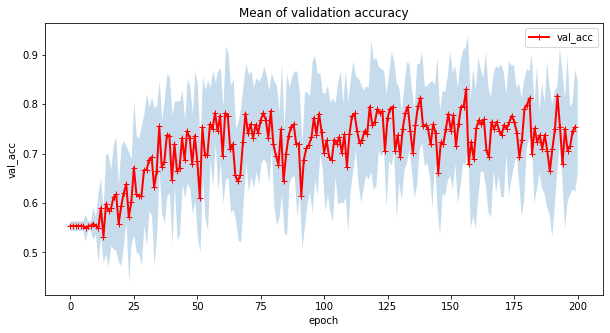

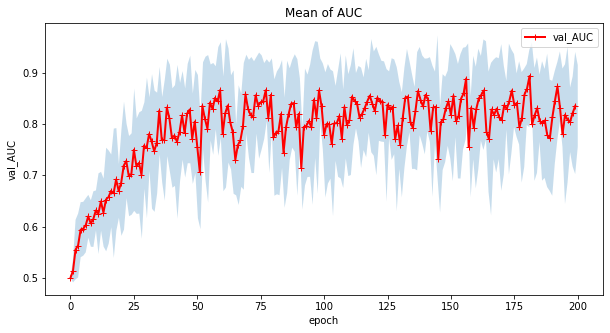

In [20]:
if (True) :   #YT be carefull overwrites the current model!!!!!!!
    FName = "noneADCNAttention_20200801-023626_results.npz"   #YT attention one
    outputpath = "V5"
    #denseADCNKorolev_20200724-004511_results.npz  #YT best model with L1
    
    #FName = "noneADCNKorolev_20200723-131526_results.npz"  #YT Best for Vox16
    #outputpath = "V3"
  
    #FName = "noneADCNKorolev_20200723-081701_results.npz"
    #outputpath = "V3"
 
    

    resultsRN = np.load(os.path.join(outputpath, FName),allow_pickle=True)
    mod, max_val, max_ROC, histories = conv2RunVars (resultsRN)
    report_Paper_loaded (mod, histories)
    mod

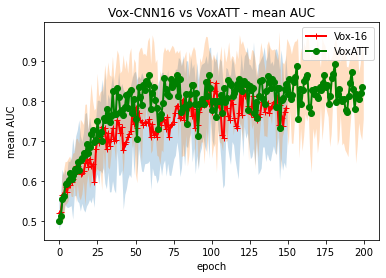

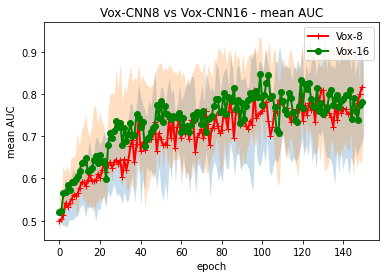

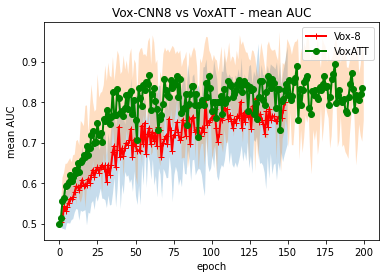

In [23]:
if (True):
    FName = "noneADCNAttention_20200801-023626_results.npz"   #YT attention one
    outputpath = "V5"
    resultsAtt = np.load(os.path.join(outputpath, FName),allow_pickle=True)
    
    FName = "noneADCNKorolev_20200723-131526_results.npz"  #YT Best for Denser One
    outputpath = "V3"
    resultsD = np.load(os.path.join(outputpath, FName),allow_pickle=True)
  
    FName = "noneADCNKorolev_20200723-081701_results.npz"
    outputpath = "V3"
    resultsOrg = np.load(os.path.join(outputpath, FName),allow_pickle=True)
 
    

    modAtt, max_valAtt, max_ROCAtt, historiesAtt = conv2RunVars (resultsAtt)
    modD, max_valD, max_ROCD, historiesD = conv2RunVars (resultsD)
    modOrg, max_valOrg, max_ROCOrg, historiesOrg = conv2RunVars (resultsOrg)

    val_AUCAtt = np.array([ v['val_AUC'] for v in historiesAtt]) 
    val_AUCD = np.array([ v['val_AUC'] for v in historiesD]) 
    val_AUCOrg = np.array([ v['val_AUC'] for v in historiesOrg]) 

    Plot2Graphs(val_AUCD, val_AUCAtt, "Vox-16", "VoxATT", "Vox-CNN16 vs VoxATT - mean AUC") 
    Plot2Graphs(val_AUCOrg, val_AUCD, "Vox-8", "Vox-16", "Vox-CNN8 vs Vox-CNN16 - mean AUC")
    Plot2Graphs(val_AUCOrg, val_AUCAtt, "Vox-8", "VoxATT", "Vox-CNN8 vs VoxATT - mean AUC")


In [22]:
print (modD)

{'dset1': 'AD', 'dset2': 'CN', 'Epochs': 150, 'batch_size': 5, 'repeats': 2, 'nFold': 5, 'nSplit': 5, 'bUseTensorBoard': False, 'lr_all': 2.7e-05, 'momentum': 0.9, 'sActivation': 'relu', 'nDropOut': 0.7, 'model': 'voxcnn', 'bBatchNorm_Cnv': False, 'bL1': False, 'bL2': False, 'Agg_mod': 'none', 'G_mod': 'Korolev', 'feature_scale': 4, 'focus_init_sigma': 0.25, 'focus_init_mu': 'spread', 'focus_train_mu': True, 'focus_train_si': True, 'focus_train_weights': True, 'focus_norm_type': 2, 'focus_sigma_reg': None, 'augment': False, 'FN_lr_all': 2.7e-05, 'nhidden': (96,), 'neuron': 'focused'}


In [22]:
mod

{'dset1': 'AD',
 'dset2': 'CN',
 'Epochs': 200,
 'batch_size': 5,
 'bUseTensorBoard': False,
 'repeats': 2,
 'nFold': 5,
 'nSplit': 5,
 'lr_all': 2.7e-05,
 'momentum': 0.9,
 'sActivation': 'relu',
 'nDropOut': 0.25,
 'model': 'voxcnn',
 'bBatchNorm_Cnv': False,
 'bL1': False,
 'bL2': False,
 'bL3': False,
 'Agg_mod': 'none',
 'G_mod': 'Attention',
 'feature_scale': 4,
 'focus_init_sigma': 1.0,
 'focus_init_mu': 'spread',
 'focus_train_mu': True,
 'focus_train_si': True,
 'focus_train_weights': True,
 'focus_norm_type': 2,
 'focus_sigma_reg': None,
 'augment': False,
 'FN_lr_all': 0.0001,
 'nhidden': (96,),
 'neuron': 'focused',
 'optimiser': 'SGD',
 'debug_FN': True}

In [23]:
if (True) : #YT be carefull overwrites the current run!!!!!!!
    outputpath = "V5"
    bestpath = os.path.join(outputpath, "noneADCNAttention_20200731-235716_bestW.hdf5")
    #bestpath = os.path.join(outputpath, "noneADCNKorolev_20200723-104400_bestW.hdf5")

    #bestpath = os.path.join(outputpath, "noneADCNAttFN_20200803-132638_bestW.hdf5")
    #bestpath = os.path.join(outputpath, "noneADCNKorolev_20200723-063922_bestW.hdf5")
    modelRN = DefineVoxCNNModel (mod)
    modelRN.load_weights(bestpath)

Tensor("global_average_pooling3d/Identity:0", shape=(None, 128), dtype=float32)
Tensor("ExpandDims_1:0", shape=(None, 6, 6, 6, 1), dtype=float32)
Tensor("mul:0", shape=(None, 6, 6, 6, 128), dtype=float32)


In [24]:
modelRN.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, 1, 110, 110, 0                                            
__________________________________________________________________________________________________
permute (Permute)               (None, 110, 110, 110 0           input[0][0]                      
__________________________________________________________________________________________________
cnv_1_16 (Conv3D)               (None, 110, 110, 110 448         permute[0][0]                    
__________________________________________________________________________________________________
cnv_2_16 (Conv3D)               (None, 110, 110, 110 6928        cnv_1_16[0][0]                   
______________________________________________________________________________________________

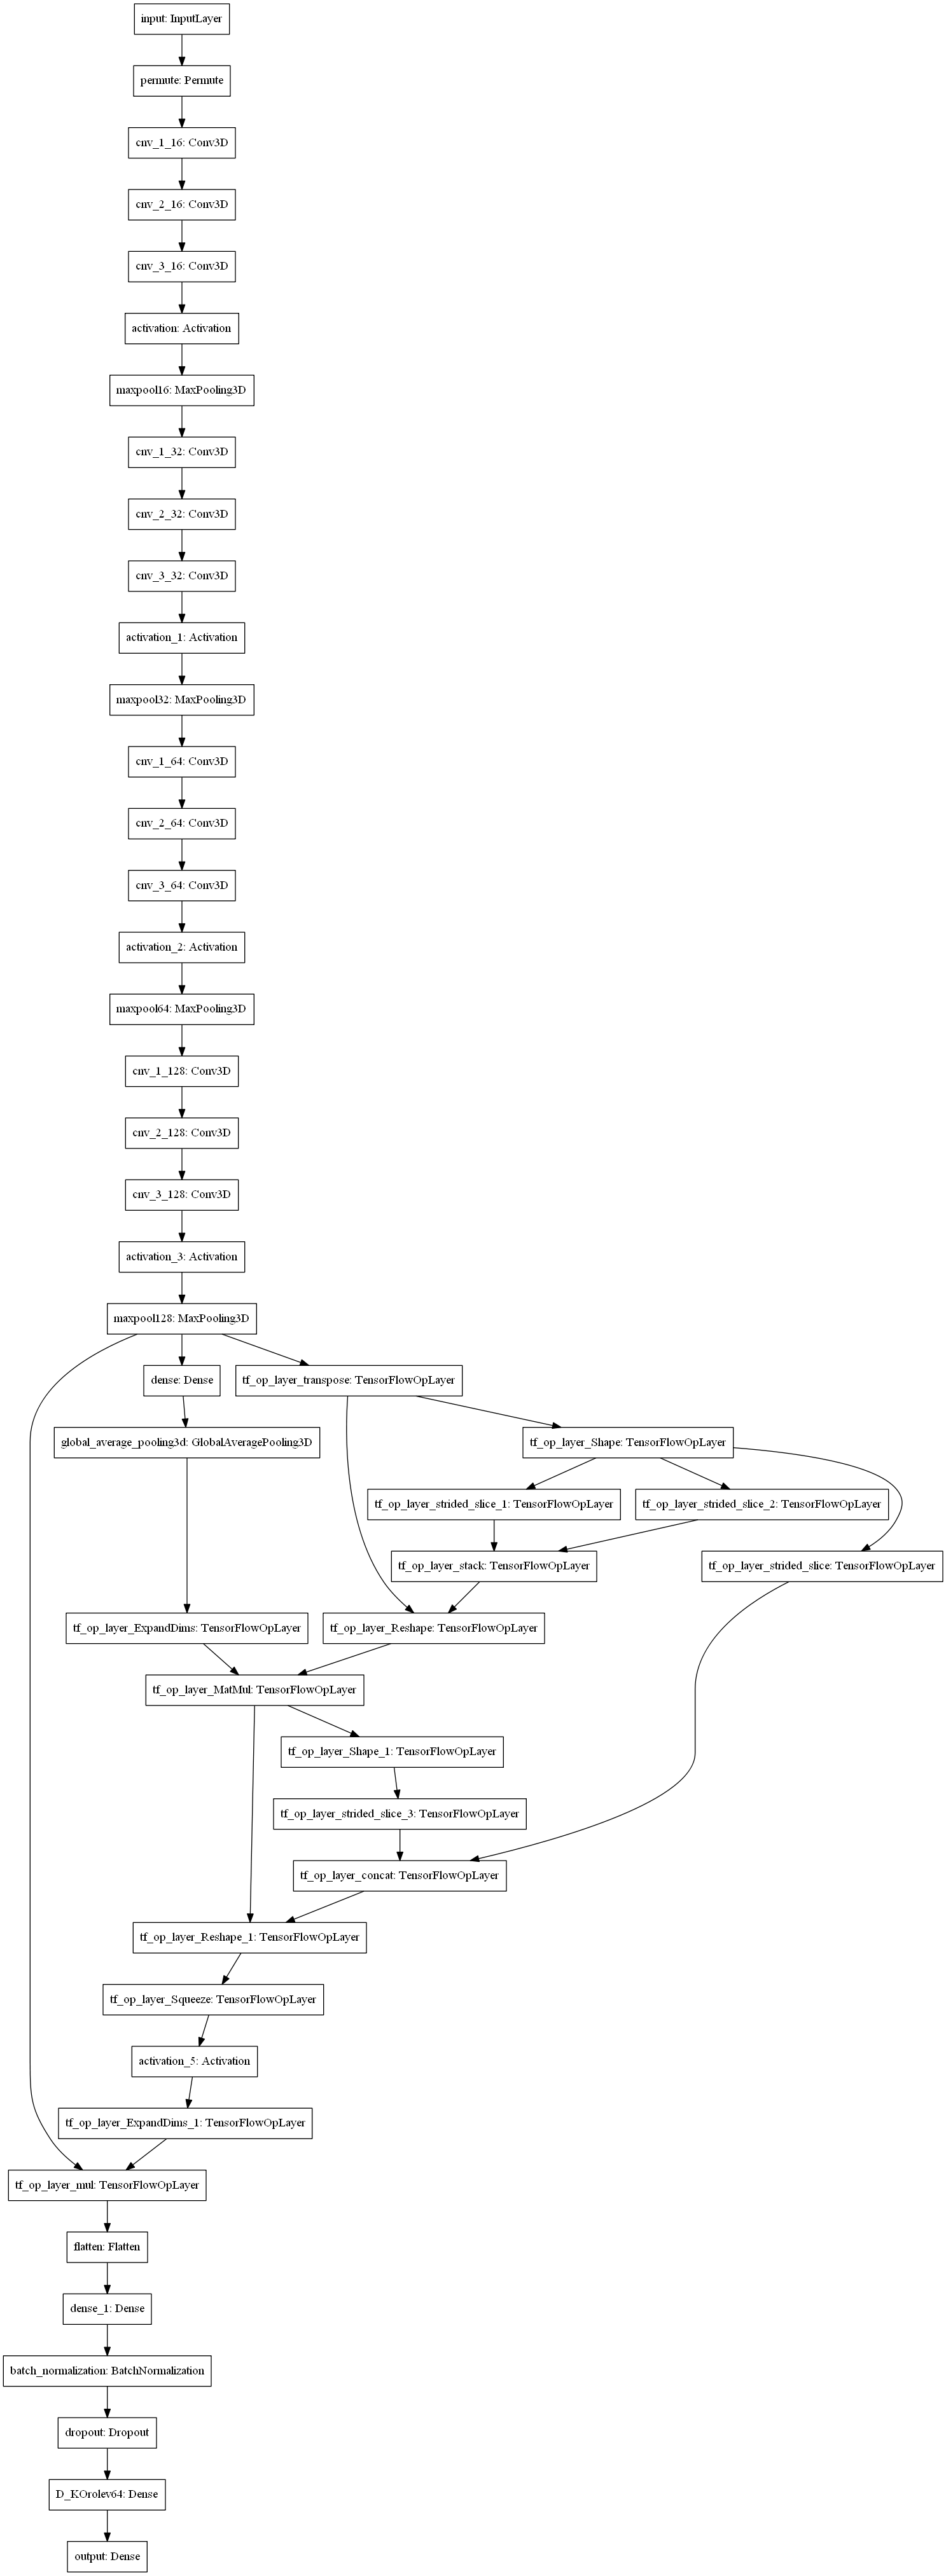

In [25]:
tf.keras.utils.plot_model(
    modelRN , to_file='report.png', show_shapes=False, show_layer_names=True,
      rankdir='TB', expand_nested=False
    )

# Occlusion

In [26]:
#YT Papers origional code
def occlusion_heatmap(net, x, label, square_size=7, batchsize=1):
    
    if (x.ndim != 5) or x.shape[0] != 1:
        raise ValueError("This function requires the input data to be of shape"
                         " (1, c, x, y, z), instead got {}".format(x.shape))
    if square_size % 2 == 0:
        raise ValueError("Square length has to be an odd number, instead "
                         "got {}.".format(square_size))

    num_classes = 2
    img = x[0].copy()
    bs, col, s0, s1, s2 = x.shape

    pad = square_size // 2 + 1
    x_occluded = np.zeros((s2, col, s0, s1, s2), dtype=img.dtype)
    probs = np.zeros((s0, s1, s2, num_classes))

    for i in range(s0):
        for j in tqdm(range(s1), desc='x = {}'.format(i)):
            batch_iter = 1
            batch = []
            for k in range(s2):
                x_pad = np.pad(img, ((0, 0), (pad, pad),
                                     (pad, pad), (pad, pad)), 'constant')
                x_pad[:,
                      i:i + square_size,
                      j:j + square_size,
                      k:k + square_size] = 0.
                x_occluded = x_pad[:, pad:-pad, pad:-pad, pad:-pad]
                batch.append(x_occluded)
                if batch_iter % batchsize == 0:
                    y_proba = net.predict_on_batch(np.array(batch).reshape((-1, 1, 110, 110, 110)))
                    probs[i, j, k - batchsize + 1:k + 1, :] = y_proba
                    batch_iter = 0
                    batch = []
                batch_iter += 1

    return probs

In [27]:
print (target)

[1 1 0 0 0 1 1 0 1 1 1 1 1 1 0 1 0 0 1 0 0 0 0 1 1 1 0 1 1 0 0 0 1 1 0 0 0
 1 1 0 1 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 0 1 1 0 1 1 1 1 0 0 1 0 1 0 1 1 1
 1 1 0 1 1 1 1 0 0 1 1 1 1 1 0 1 0 0 1 1 0 1 1 0 1 0 0 0 0 0 0 0 1 1 1 1 1
 1]


In [28]:
if (True):
    nSplit = 0
    for cvrand in range(mod['repeats']):
        #YT stratified test and train data is very needed for the learning with this data.
        skf = StratifiedKFold(n_splits=mod['nSplit'], random_state=42 * (cvrand+1),
                        shuffle=True)
        for train_index, test_index in skf.split(data, target):
            print("TRAIN:", train_index, "TEST:", test_index)
            #print(test_index)
            print (target[test_index])
            #np.save("test_split_"+str(nSplit), test_index)
            #np.save("train_split_"+str(nSplit), train_index)
            nSplit= nSplit+1
            #X_train, y_train = data[train_index], target[train_index]
            #X_test, y_test = data[test_index], target[test_index]


TRAIN: [  0   1   2   4   6   7   9  10  12  13  14  15  16  19  20  21  22  23
  24  25  26  27  29  31  32  33  35  36  40  42  43  44  45  46  47  48
  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  66  67
  68  69  70  72  73  74  75  77  78  80  81  82  84  85  86  87  88  89
  90  91  93  95  96  98 100 101 102 103 104 105 107 108 109 110 111] TEST: [  3   5   8  11  17  18  28  30  34  37  38  39  41  65  71  76  79  83
  92  94  97  99 106]
[0 1 1 1 0 1 1 0 0 1 1 0 1 0 1 0 1 1 1 0 0 0 1]
TRAIN: [  0   1   2   3   4   5   6   7   8   9  11  13  15  16  17  18  19  20
  22  23  25  26  27  28  29  30  33  34  36  37  38  39  40  41  42  43
  44  45  46  48  49  50  53  54  55  56  57  58  59  60  62  63  64  65
  68  69  70  71  72  73  74  75  76  77  78  79  81  82  83  84  85  86
  89  90  91  92  94  96  97  99 100 101 104 105 106 107 109 110 111] TEST: [ 10  12  14  21  24  31  32  35  47  51  52  61  66  67  80  87  88  93
  95  98 102 103 108]
[1 1 0 0 1 0

In [29]:
def PrintOcclusion (data, res) :
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.axis('off')

    matr = rotate(data[:, :, :, 47].reshape(110, 110), 90)
    plt.imshow(matr, "gray")
#    plt.hold(True)

    matr = rotate(res[:, :, 47, 0].reshape(110, 110), 90)
    plt.imshow(1. * (np.ma.masked_where(matr > .99, matr)),
           interpolation=None, vmax=1., vmin=.0, alpha=.8,
           cmap=plt.cm.viridis_r)
    
    plt.subplot(1, 2, 2)
    plt.axis('off')

    matr = rotate(data[:, 57, :, :].reshape(110, 110), 90)
    plt.imshow(matr, cmap="gray")
#    plt.hold(True)

    matr = rotate(res[57, :, :, 0].reshape(110, 110), 90)
    plt.imshow(1. * (np.ma.masked_where(matr > .99, matr)),
           interpolation=None, vmax=1., vmin=.0, alpha=.8,
           cmap=plt.cm.viridis_r)
    
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=20)
    plt.show()

In [30]:
if (True):
    #res = np.load ("occ_att_d3.npy")
    #res0 = np.load ("occ_att_d1_N.npy")
    test_split = np.load("test_split_5.npy")
    print (test_split, len(test_split))
    print (target[test_split])


[ 3  6 11 18 26 33 39 42 45 46 53 55 58 62 67 73 81 83 89 90 92 96 99] 23
[0 1 1 1 0 1 0 0 0 1 0 0 1 1 1 1 0 1 1 0 1 1 0]


In [31]:

def Predict_tests(net, test_index):
    
    y_proba = net.predict(np.array(data[test_index]).reshape((-1, 1, 110, 110, 110)))
    print (test_index, y_proba, target[test_index])
   

In [32]:
if (True) :
    for i in range(len(test_split)) :
        Predict_tests(modelRN,test_split[i])

3 [[0.9594147  0.04058529]] 0
6 [[3.3011872e-08 1.0000000e+00]] 1
11 [[3.2113172e-07 9.9999964e-01]] 1
18 [[0.03632141 0.96367854]] 1
26 [[0.9607466  0.03925337]] 0
33 [[0.08109631 0.91890365]] 1
39 [[0.9857056  0.01429438]] 0
42 [[0.70262605 0.29737395]] 0
45 [[0.05524395 0.94475603]] 0
46 [[0.08029093 0.91970915]] 1
53 [[9.9994326e-01 5.6797478e-05]] 0
55 [[0.9933652  0.00663478]] 0
58 [[0.01755945 0.98244053]] 1
62 [[5.9219499e-05 9.9994075e-01]] 1
67 [[0.30216306 0.69783694]] 1
73 [[0.06723608 0.93276393]] 1
81 [[0.5051948  0.49480525]] 0
83 [[0.07500231 0.9249977 ]] 1
89 [[3.3071882e-04 9.9966931e-01]] 1
90 [[0.9962578  0.00374224]] 0
92 [[0.0430521  0.95694786]] 1
96 [[2.3031561e-04 9.9976975e-01]] 1
99 [[0.9988801 0.0011199]] 0


In [33]:
target

array([1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0,
       0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       1, 1])

In [34]:
#YT Papers origional code
if (False) :
    res_oc_eg = occlusion_heatmap(modelRN, data[111].reshape(1, 1, 110, 110, 110), 1, 7, 11)
    np.save ("occ_att_111_096_CN", res_oc_eg)
    #np.save ("data_3",data[3])


In [35]:
#PrintOcclusion (data[3],res)
PrintOcclusion (data[70],res_oc_eg)
#PrintOcclusion (data[3],res0)

NameError: name 'res_oc_eg' is not defined

In [36]:
print (res_oc_eg)

NameError: name 'res_oc_eg' is not defined

In [37]:
def Print3Slices (pic, ptype, color="gray"):

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 3, 1)
    
    if (ptype == "data") or (ptype == "shap"):
        matr = rotate(pic[0,:,:, 60].reshape(110, 110), 90)
    elif (ptype=="res"):
        matr = rotate(pic[:,:,60,0].reshape(110, 110), 90)
        
    if color == "gray" : 
        plt.imshow(matr, cmap="gray")
    else:
        plt.imshow(matr)

    plt.subplot(1, 3, 2)
    if (ptype == "data") or (ptype == "shap"):
        matr = rotate(pic[0, :, 60, :].reshape(110, 110), 90)
    elif (ptype=="res"):
        matr = rotate(pic[:,60,:, 0].reshape(110, 110), 90)
    
    if color == "gray" : 
        plt.imshow(matr, cmap="gray")
    else:
        plt.imshow(matr)


    plt.subplot(1, 3, 3)
    if (ptype == "data") or (ptype == "shap"):
        matr = rotate(pic[0,60, :, :].reshape(110, 110), 90)
    elif (ptype=="res"):
        matr = rotate(pic[60,:,:,0].reshape(110, 110), 90)
    
    if color == "gray" : 
        plt.imshow(matr, cmap="gray")
    else:
        plt.imshow(matr)

    #cbar = plt.colorbar()
    plt.show() 

In [38]:
Print3Slices(res_oc_eg,"res",color="color")

NameError: name 'res_oc_eg' is not defined

In [39]:
def Print3Occ(res, thres):

    seg0_name = '..\\vimages\\3DUCM\\example_level_00.npy'
    seg0 = np.load(seg0_name)
    seg0 = np.flipud(seg0)
    seg0_array = np.unique(seg0)
    vox_cnt = []

    for cc in range(len(seg0_array)):
        vox_cnt.append(len(np.where(seg0==seg0_array[cc])[0]))
    bg_seg = seg0_array[np.where(np.array(vox_cnt) == max(vox_cnt))[0]][0]

    res[np.where(seg0==bg_seg)] = 0
    
    res = (res - np.min(res)) / (np.max(res) - np.min(res))
    res = resize(res,(256,256,256))
    
    fig = plt.figure(figsize=(21, 5))
    plt.subplot(1, 3, 1)
    plt.axis('off')
    matr = rotate(mri_rz[:, :, 128].reshape(256, 256), 90)
    plt.imshow(matr, cmap=plt.cm.Greys_r, interpolation=None,
           vmax=1., vmin=0.)
    #plt.hold(True)
    matr = rotate(res[:, :, 128].reshape(256, 256), 90)
    plt.imshow(matr,
           interpolation=None, alpha=0.8,vmax=1, vmin=.0,
           cmap=plt.cm.rainbow) #cmap=plt.cm.rainbow) 
#    plt.imshow(200. * (1-np.ma.masked_where(matr > 0.56, matr)),
#           interpolation=None, vmax=1., vmin=.0, alpha=.8,
#           cmap=plt.cm.viridis_r)
 
    plt.subplot(1, 3, 2)
    plt.axis('off')
    matr = rotate(mri_rz[128,:, :].reshape(256, 256), 90)
    plt.imshow(matr, cmap=plt.cm.Greys_r, interpolation=None,
           vmax=1., vmin=0)
    #plt.hold(True)
    matr = rotate(res[128,:, :].reshape(256, 256), 90)
    plt.imshow(matr,
           interpolation=None, alpha=0.8,vmax=1, vmin=.0,
           cmap=plt.cm.rainbow) #cmap=plt.cm.rainbow) 
#    plt.imshow(200. * (1-np.ma.masked_where(matr > 0.56, matr)),
#           interpolation=None, vmax=1., vmin=.0, alpha=.8,
#           cmap=plt.cm.viridis_r)
    plt.subplot(1, 3, 3)
    plt.axis('off')
    matr = rotate(mri_rz[:,128, :].reshape(256, 256), 90)
    plt.imshow(matr, cmap=plt.cm.Greys_r, interpolation=None,
           vmax=1., vmin=0.)
    #plt.hold(True)
    matr = rotate(res[:,128, :].reshape(256, 256), 90)
    plt.imshow(matr,
           interpolation=None, alpha=0.8,vmax=1, vmin=.0,
           cmap=plt.cm.rainbow) #cmap=plt.cm.rainbow) 
#    plt.imshow(200. * (1-np.ma.masked_where(matr > 0.56, matr)),
#           interpolation=None, vmax=1., vmin=.0, alpha=.8,
#           cmap=plt.cm.viridis_r)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=20)
    plt.show()

In [40]:
def print_occlusionCN(org_im, res):

    plt.figure(figsize=(14, 5))
    plt.subplot(1, 2, 1)
    plt.axis('off')
    matr = rotate(org_im[:, :, :, 47].reshape(110, 110), 90)
    plt.imshow(matr, cmap=plt.cm.Greys_r, interpolation=None,
           vmax=1., vmin=0.)
    #plt.hold(True)
    matr = rotate(res[:, :, 47, 0].reshape(110, 110), 90)
    plt.imshow(1. * (np.ma.masked_where(matr > .96, matr)),
           interpolation=None, vmax=1., vmin=.0, alpha=.3,
           cmap=plt.cm.viridis_r)
    plt.subplot(1, 2, 2)
    plt.axis('off')
    matr = rotate(org_im[:, 57, :, :].reshape(110, 110), 90)
    plt.imshow(matr, cmap=plt.cm.Greys_r, interpolation=None,
           vmax=1., vmin=0.)
    #plt.hold(True)
    matr = rotate(res[57, :, :, 0].reshape(110, 110), 90)
    plt.imshow(1. * (np.ma.masked_where(matr > .96, matr)),
           interpolation=None, vmax=1., vmin=.0, alpha=.3,
           cmap=plt.cm.viridis_r)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=20)
    plt.show()

In [41]:
print_occlusionCN(data[110],res_oc_eg)

NameError: name 'res_oc_eg' is not defined

In [42]:
res_oc_eg = np.load("PaperHeatmapsOcc\\occ_vox16_110_079_CN.npy")
res_oc = copy.deepcopy(res_oc_eg[:,:,:,1])


In [137]:
res_oc_eg.shape, res_oc.shape

((110, 110, 110, 2), (110, 110, 110))

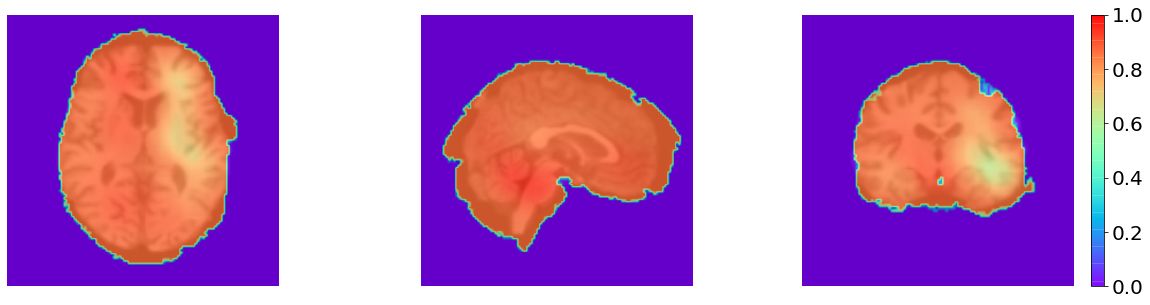

In [142]:
Print3Occ(res_oc)

# 3D-UCM

In [43]:
def Calc3DUCM(model, mri):
    #level_list = glob.glob('vmages\3DUCM\example_level_*')
    path = '..\\vimages\\3DUCM'
    level_list = os.listdir(path)
    level_list.pop(0)
    #print (level_list)
    prob_list = []
    for k in tqdm(range(len(level_list))):

        segname = os.path.join(path,level_list[k])
        segs = np.load(segname)
        segs = np.flipud(segs)

        s0, s1, s2 = mri.shape
        num_classes = 2
        probs = np.zeros((s0, s1, s2, num_classes))
        seg_array = np.unique(segs)

        for j in range(len(seg_array)):

            x_occluded = copy.deepcopy(mri)
            x_occluded[np.where(segs==seg_array[j])] = 0
            y_proba = model.predict(np.array(x_occluded).reshape((-1, 1, 110, 110, 110)), batch_size=5)
            probs[np.where(segs==seg_array[j])] = y_proba
            #print(y_proba)

        prob_list.append(probs)

    prob_map = np.zeros(mri.shape)

    for ll in range(len(prob_list)):
        prob_map = prob_map + prob_list[ll][:,:,:,0]

    prob_map = prob_map / np.float(len(prob_list))

    res = (prob_map - np.min(prob_map)) / (np.max(prob_map) - np.min(prob_map))
    
    return res

In [44]:
def Print3DUCM(res,mri_rz):
    seg0_name = '..\\vimages\\3DUCM\\example_level_00.npy'
    seg0 = np.load(seg0_name)
    seg0 = np.flipud(seg0)
    seg0_array = np.unique(seg0)
    vox_cnt = []

    for cc in range(len(seg0_array)):
        vox_cnt.append(len(np.where(seg0==seg0_array[cc])[0]))
    bg_seg = seg0_array[np.where(np.array(vox_cnt) == max(vox_cnt))[0]][0]

    res[np.where(seg0==bg_seg)] = 0

    res = resize(res,(256,256,256))
  
    fig = plt.figure(figsize=(21, 5))
    plt.subplot(1, 3, 1)
    plt.axis('off')
    matr = rotate(mri_rz[:, :, 128].reshape(256, 256), 90)
    plt.imshow(matr, cmap=plt.cm.Greys_r, interpolation=None,
           vmax=1., vmin=0.)
    #plt.hold(True)
    matr = rotate(res[:, :, 128].reshape(256, 256), 90)
    plt.imshow(matr,
           interpolation=None, vmax=1., vmin=.0, alpha=0.8,
           cmap=plt.cm.rainbow)
    plt.subplot(1, 3, 2)
    plt.axis('off')
    matr = rotate(mri_rz[128,:, :].reshape(256, 256), 90)
    plt.imshow(matr, cmap=plt.cm.Greys_r, interpolation=None,
           vmax=1., vmin=0.)
    #plt.hold(True)
    matr = rotate(res[128,:, :].reshape(256, 256), 90)
    plt.imshow(matr,
           interpolation=None, vmax=1., vmin=.0, alpha=0.8,
           cmap=plt.cm.rainbow)
    plt.subplot(1, 3, 3)
    plt.axis('off')
    matr = rotate(mri_rz[:,128, :].reshape(256, 256), 90)
    plt.imshow(matr, cmap=plt.cm.Greys_r, interpolation=None,
           vmax=1., vmin=0.)
    #plt.hold(True)
    matr = rotate(res[:,128, :].reshape(256, 256), 90)
    plt.imshow(matr,
           interpolation=None, vmax=1., vmin=.0, alpha=0.8,
           cmap=plt.cm.rainbow)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=20)
    plt.show()

In [205]:
mri = data[110][0]
mri_rz = resize(mri,(256,256,256))

In [144]:
#YT Run 3DUCM 
res = Calc3DUCM(modelRN, mri)


  0%|          | 0/19 [00:00<?, ?it/s]

['example_level_00.npy', 'example_level_01.npy', 'example_level_02.npy', 'example_level_03.npy', 'example_level_04.npy', 'example_level_05.npy', 'example_level_06.npy', 'example_level_07.npy', 'example_level_08.npy', 'example_level_09.npy', 'example_level_10.npy', 'example_level_11.npy', 'example_level_12.npy', 'example_level_13.npy', 'example_level_14.npy', 'example_level_15.npy', 'example_level_16.npy', 'example_level_17.npy', 'example_level_18.npy']


100%|██████████| 19/19 [01:44<00:00,  5.49s/it]


3DUCM


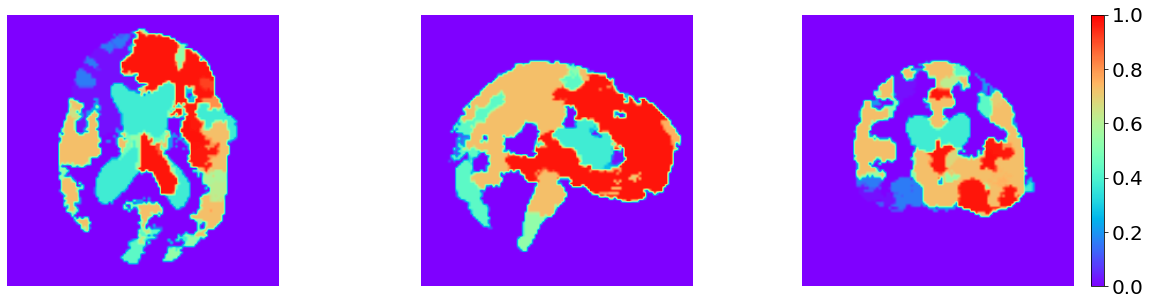

In [206]:
print('3DUCM')
Print3DUCM(res,mri_rz)

# 3D_GRAD_CAM

In [45]:
def Calc_3D_Grad_CAM (model, mri, mri_rz, layer_name = 'conv3d_9') :
    LAYER_NAME = layer_name  #YT last convolutional layer
    CAT_CLASS_INDEX = 0

    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(LAYER_NAME).output, model.output])

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(mri.reshape(1,1,110,110,110))
        loss = predictions[:, CAT_CLASS_INDEX]

    output = conv_outputs[0]
    grads = tape.gradient(loss, conv_outputs)[0]

#gate_f = tf.cast(output > 0, 'float32')
#gate_r = tf.cast(grads > 0, 'float32')
    guided_grads = tf.cast(output > 0, 'float32') * tf.cast(grads > 0, 'float32') * grads

    weights = tf.reduce_mean(guided_grads, axis=(1,2,3)) #YT last dims

    cam = np.zeros(dtype = np.float32, shape = conv_outputs.shape[2:5])

    for i, w in enumerate(weights):
        cam += w * output[i,:, :, :]

    res = (cam - np.min(cam)) / (np.max(cam) - np.min(cam))   

    seg0_name = '..\\vimages\\3DUCM\\example_level_00.npy'
    seg0 = np.load(seg0_name)
    seg0 = np.flipud(seg0)
    seg0_array = np.unique(seg0)
    vox_cnt = []

    for cc in range(len(seg0_array)):
        vox_cnt.append(len(np.where(seg0==seg0_array[cc])[0]))
    bg_seg = seg0_array[np.where(np.array(vox_cnt) == max(vox_cnt))[0]][0]

    res = resize(res,(110,110,110))
    res[np.where(seg0==bg_seg)] = 0

    res[np.where(seg0==bg_seg)] = 0

    res = resize(res,(256,256,256))
    
    fig = plt.figure(figsize=(21, 5))
    plt.subplot(1, 3, 1)
    plt.axis('off')
    matr = rotate(mri_rz[:, :, 128].reshape(256, 256), 90)
    plt.imshow(matr, cmap=plt.cm.Greys_r, interpolation=None,
           vmax=1., vmin=0.)
    #plt.hold(True)
    matr = rotate(res[:, :, 128].reshape(256, 256), 90)
    plt.imshow(matr,
           interpolation=None, vmax=1., vmin=.0, alpha=1,
           cmap=plt.cm.rainbow)
    plt.subplot(1, 3, 2)
    plt.axis('off')
    matr = rotate(mri_rz[128,:, :].reshape(256, 256), 90)
    plt.imshow(matr, cmap=plt.cm.Greys_r, interpolation=None,
           vmax=1., vmin=0.)
    #plt.hold(True)
    matr = rotate(res[128,:, :].reshape(256, 256), 90)
    plt.imshow(matr,
           interpolation=None, vmax=1., vmin=.0, alpha=1,
           cmap=plt.cm.rainbow)
    plt.subplot(1, 3, 3)
    plt.axis('off')
    matr = rotate(mri_rz[:,128, :].reshape(256, 256), 90)
    plt.imshow(matr, cmap=plt.cm.Greys_r, interpolation=None,
           vmax=1., vmin=0.)
    #plt.hold(True)
    matr = rotate(res[:,128, :].reshape(256, 256), 90)
    plt.imshow(matr,
           interpolation=None, vmax=1., vmin=.0, alpha=1,
           cmap=plt.cm.rainbow)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=20)
    plt.show()    
    
    return res


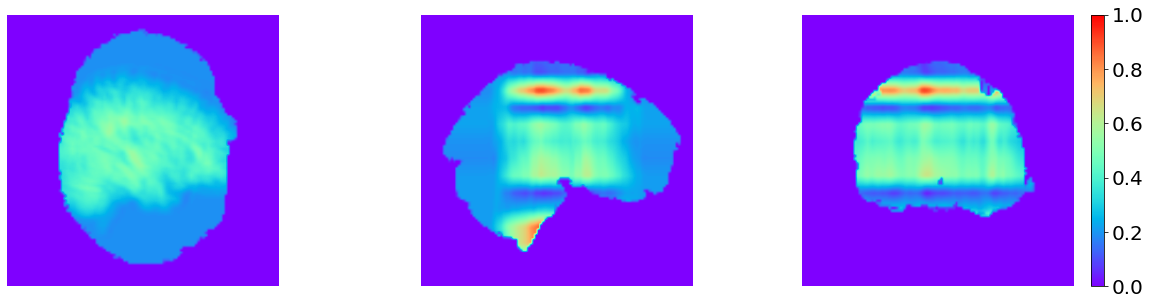

In [208]:
#YT run 3D_GRAD_CAM
lyr_name = 'cnv_3_16'
res_CAM = Calc_3D_Grad_CAM (modelRN, mri, layer_name = lyr_name)


# Shap

In [47]:
def PrintShap(res,mri_rz):

    seg0_name = '..\\vimages\\3DUCM\\example_level_00.npy'
    seg0 = np.load(seg0_name)
    seg0 = np.flipud(seg0)
    seg0_array = np.unique(seg0)
    vox_cnt = []

    for cc in range(len(seg0_array)):
        vox_cnt.append(len(np.where(seg0==seg0_array[cc])[0]))
    bg_seg = seg0_array[np.where(np.array(vox_cnt) == max(vox_cnt))[0]][0]

    res[np.where(seg0==bg_seg)] = 0

    res = resize(res,(256,256,256))

    fig = plt.figure(figsize=(21, 5))
    plt.subplot(1, 3, 1)
    plt.axis('off')
    matr = rotate(mri_rz[:, :, 128].reshape(256, 256), 90)
    plt.imshow(matr, cmap=plt.cm.Greys_r, interpolation=None,
           vmax=1., vmin=0.)
    #plt.hold(True)
    matr = rotate(res[:, :, 128].reshape(256, 256), 90)
    plt.imshow(100*matr,
           interpolation=None, alpha=0.9,vmax=0.01, vmin=-0.01,
           cmap=plt.cm.rainbow) #cmap=plt.cm.rainbow) 
#    plt.imshow(200. * (1-np.ma.masked_where(matr > 0.56, matr)),
#           interpolation=None, vmax=1., vmin=.0, alpha=.8,
#           cmap=plt.cm.viridis_r)
 
    plt.subplot(1, 3, 2)
    plt.axis('off')
    matr = rotate(mri_rz[128,:, :].reshape(256, 256), 90)
    plt.imshow(matr, cmap=plt.cm.Greys_r, interpolation=None,
           vmax=1., vmin=0)
    #plt.hold(True)
    matr = rotate(res[128,:, :].reshape(256, 256), 90)
    plt.imshow(100*matr,
           interpolation=None, alpha=0.9,vmax=0.01, vmin=-0.01,
           cmap=plt.cm.rainbow) #cmap=plt.cm.rainbow) 
#    plt.imshow(200. * (1-np.ma.masked_where(matr > 0.56, matr)),
#           interpolation=None, vmax=1., vmin=.0, alpha=.8,
#           cmap=plt.cm.viridis_r)
    plt.subplot(1, 3, 3)
    plt.axis('off')
    matr = rotate(mri_rz[:,128, :].reshape(256, 256), 90)
    plt.imshow(matr, cmap=plt.cm.Greys_r, interpolation=None,
           vmax=1., vmin=0.)
    #plt.hold(True)
    matr = rotate(res[:,128, :].reshape(256, 256), 90)
    plt.imshow(100*matr,
           interpolation=None, alpha=0.9,vmax=0.01, vmin=-0.01,
           cmap=plt.cm.rainbow) #cmap=plt.cm.rainbow) 
#    plt.imshow(200. * (1-np.ma.masked_where(matr > 0.56, matr)),
#           interpolation=None, vmax=1., vmin=.0, alpha=.8,
#           cmap=plt.cm.viridis_r)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=20)
    plt.show()

passed gradientexplainer
shap index [[1 0]]


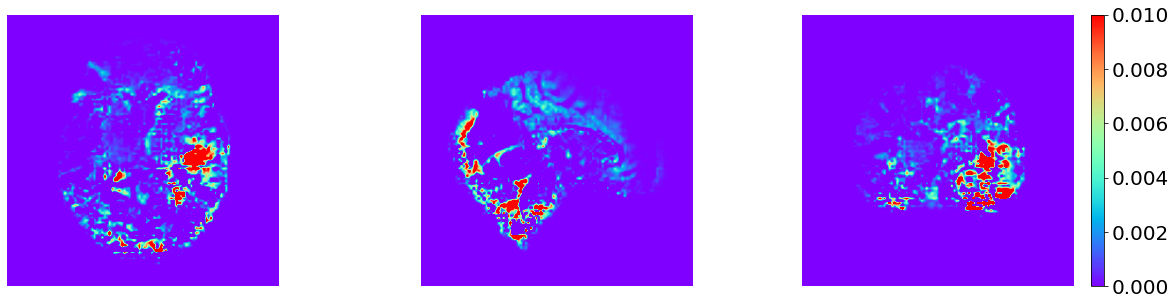

In [210]:

#YT Run shap
e = shap.GradientExplainer(modelRN,  data, batch_size=5)
print ('passed gradientexplainer')
shap_values, index = e.shap_values(mri.reshape(1,1,110,110,110),ranked_outputs=2)
print ("shap index", index)
res_shap = copy.deepcopy(shap_values[0][0,0,:,:,:])
PrintShap(res_shap)


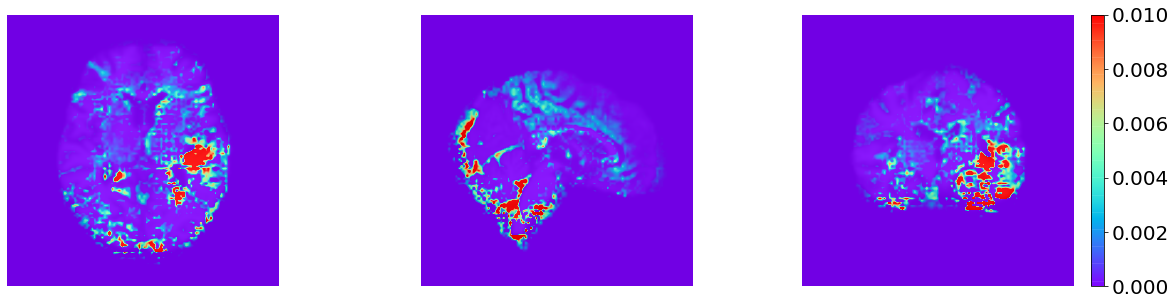

In [212]:
PrintShap(res_shap)

# Paper Report

## Occlusion

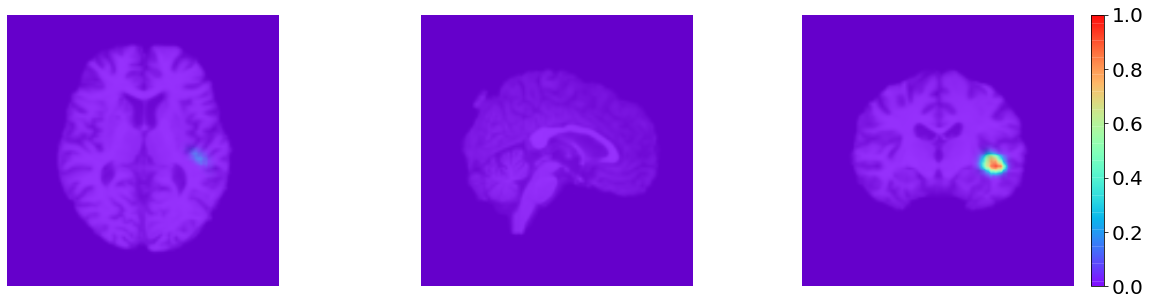

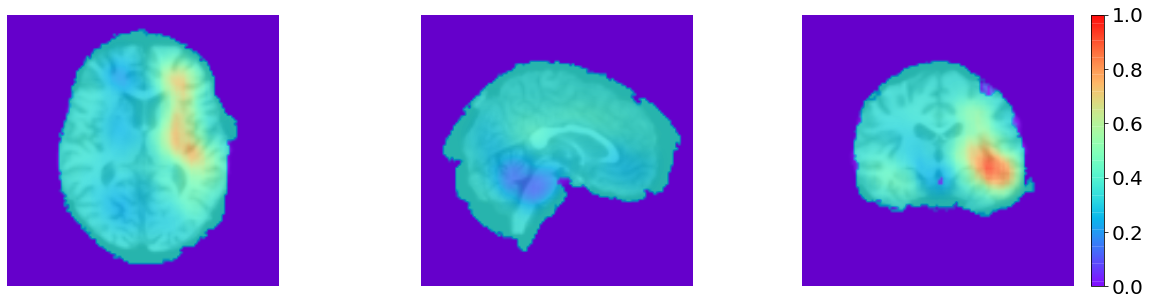

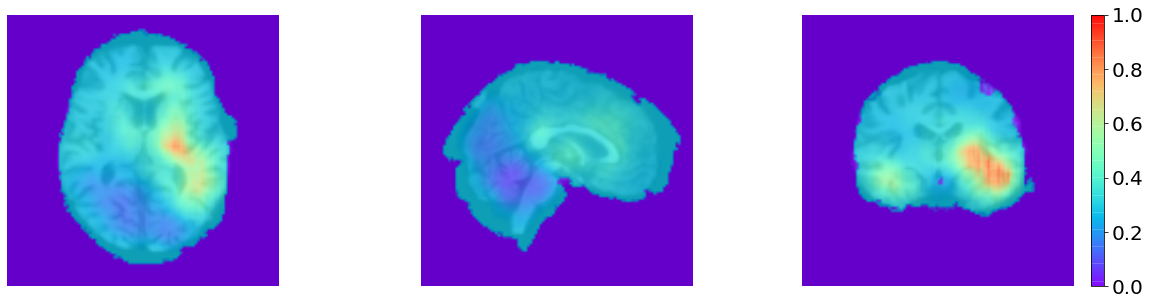

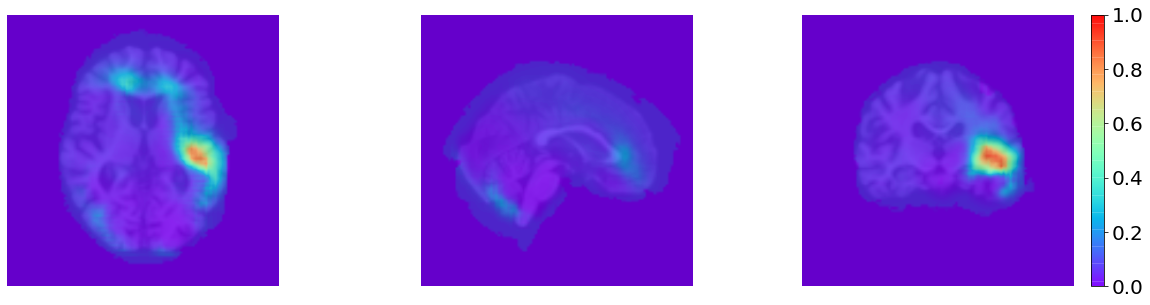

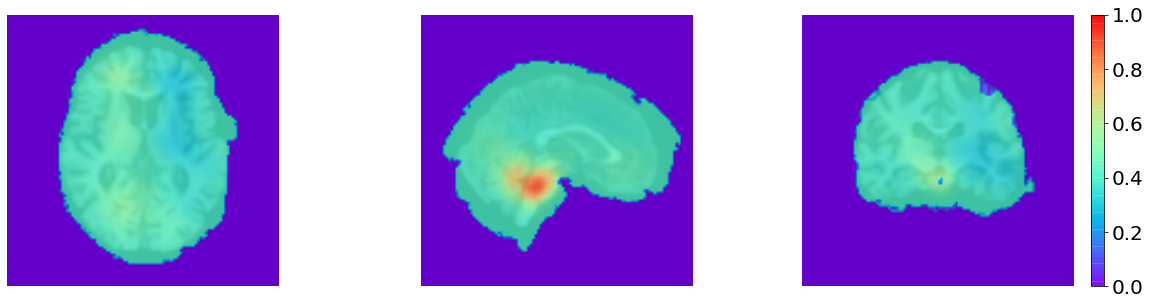

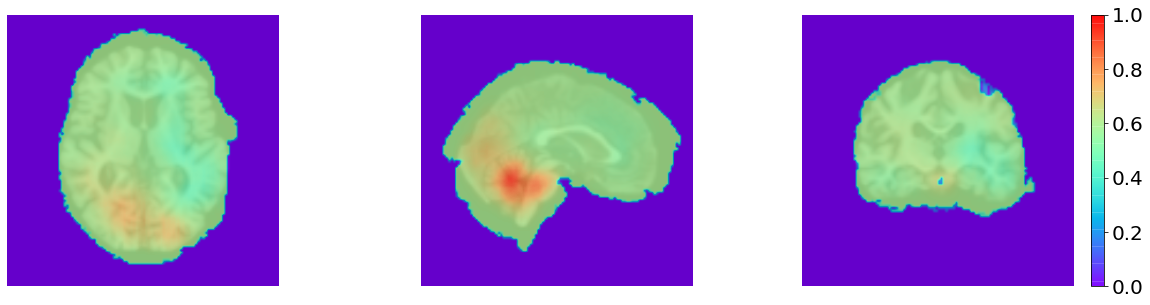

In [48]:

mri = data[110][0]
mri_rz = resize(mri,(256,256,256))
thres = 0.99
res_oc_att = np.load("PaperHeatmapsOcc\\occ_att_110_099_CN.npy")
res_oc_Vox16 = np.load("PaperHeatmapsOcc\\occ_vox16_110_079_CN.npy")
res_oc_org = np.load("PaperHeatmapsOcc\\occ_org_110_097_CN.npy")
oc_att = copy.deepcopy(res_oc_att[:,:,:,0])
oc_Vox16 = copy.deepcopy(res_oc_Vox16[:,:,:,0])
oc_org = copy.deepcopy(res_oc_org[:,:,:,0])
Print3Occ(oc_att,thres)
Print3Occ(oc_Vox16,thres)
Print3Occ(oc_org,thres)

mri = data[111][0]
mri_rz = resize(mri,(256,256,256))
res_oc_att = np.load("PaperHeatmapsOcc\\occ_att_111_096_CN.npy")
res_oc_Vox16 = np.load("PaperHeatmapsOcc\\occ_vox16_111_021_CN.npy")
res_oc_org = np.load("PaperHeatmapsOcc\\occ_org_111_023_CN.npy")
oc_att = copy.deepcopy(res_oc_att[:,:,:,0])
oc_Vox16 = copy.deepcopy(res_oc_Vox16[:,:,:,1])
oc_org = copy.deepcopy(res_oc_org[:,:,:,1])
Print3Occ(oc_att,thres)
Print3Occ(oc_Vox16,thres)
Print3Occ(oc_org,thres)

In [48]:
def PrintResults (nData, FName, outputpath, bestpath, sMName, bOcc,b3DUCM, bCAM, bShap) :
    lyr_name = 'cnv_3_16'
    
    resultsAtt = np.load(os.path.join(outputpath, FName),allow_pickle=True)
    modAtt, max_valAtt, max_ROCAtt, historiesAtt = conv2RunVars (resultsAtt)
    bestpath = os.path.join(outputpath, bestpath)
    modelRN = DefineVoxCNNModel (modAtt)
    modelRN.load_weights(bestpath)
    mri = data[nData][0]
    mri_rz = resize(mri,(256,256,256))   

    
    Predict_tests(modelRN, nData)
    
    if (bOcc) :
        res_oc_eg = occlusion_heatmap(modelRN, data[nData].reshape(1, 1, 110, 110, 110), 1, 7, 11)
        np.save ("occ_"+sMName+ str(nData)+"_AD", res_oc_eg)
    
    if (b3DUCM):
        print ("3DUCM")
        res = Calc3DUCM(modelRN, mri)
        Print3DUCM(res,mri_rz)
    
    if (bCAM):
        print ("CAM 1st conv.")
        res_CAM = Calc_3D_Grad_CAM (modelRN, mri, mri_rz, layer_name = lyr_name)
        print ("CAM last conv.")
        lyr_name = 'cnv_3_128'
        res_CAM = Calc_3D_Grad_CAM (modelRN, mri, mri_rz, layer_name = lyr_name)

    if (bShap):
        print ("Shap")
        e = shap.GradientExplainer(modelRN,  data, batch_size=5)
        shap_values, index = e.shap_values(mri.reshape(1,1,110,110,110),ranked_outputs=2)
        res_shap = copy.deepcopy(shap_values[0][0,0,:,:,:])
        PrintShap(res_shap,mri_rz)

    

In [49]:
def PrintResultsOrg (nData,FName, outputpath, bestpath, sMName, bOcc,b3DUCM, bCAM, bShap) :
    lyr_name = 'cnv_3_8'
    
    resultsAtt = np.load(os.path.join(outputpath, FName),allow_pickle=True)
    modAtt, max_valAtt, max_ROCAtt, historiesAtt = conv2RunVars (resultsAtt)
    bestpath = os.path.join(outputpath, bestpath)
    modelRN = DefineVoxCNNModel (modAtt)
    modelRN.load_weights(bestpath)
    mri = data[nData][0]
    mri_rz = resize(mri,(256,256,256))   
    
    Predict_tests(modelRN, nData)
    
    if (bOcc) :
        res_oc_eg = occlusion_heatmap(modelRN, data[nData].reshape(1, 1, 110, 110, 110), 1, 7, 11)
        np.save ("occ_"+sMName+ str(nData)+"_AD", res_oc_eg)
 
    
    if (b3DUCM):
        print ("3DUCM")
        res_UCM = Calc3DUCM(modelRN, mri)
        Print3DUCM(res_UCM,mri_rz)
    
    if (bCAM):
        print ("CAM 1st conv.")
        res_CAM = Calc_3D_Grad_CAM (modelRN, mri, mri_rz, layer_name = lyr_name)
        print ("CAM last conv.")
        lyr_name = 'cnv_3_64'
        res_CAM = Calc_3D_Grad_CAM (modelRN, mri, mri_rz, layer_name = lyr_name)

    if (bShap):
        print ("Shap")
        e = shap.GradientExplainer(modelRN,  data, batch_size=5)
        shap_values, index = e.shap_values(mri.reshape(1,1,110,110,110),ranked_outputs=2)
        res_shap = copy.deepcopy(shap_values[0][0,0,:,:,:])
        PrintShap(res_shap,mri_rz)


## 3D-UCM, 3D-GRAD-CAM, SHAP


MRI No:   81
Attention
Tensor("global_average_pooling3d/Identity:0", shape=(None, 128), dtype=float32)
Tensor("ExpandDims_1:0", shape=(None, 6, 6, 6, 1), dtype=float32)
Tensor("mul:0", shape=(None, 6, 6, 6, 128), dtype=float32)
81 [[0.5051948  0.49480525]] 0
Shap


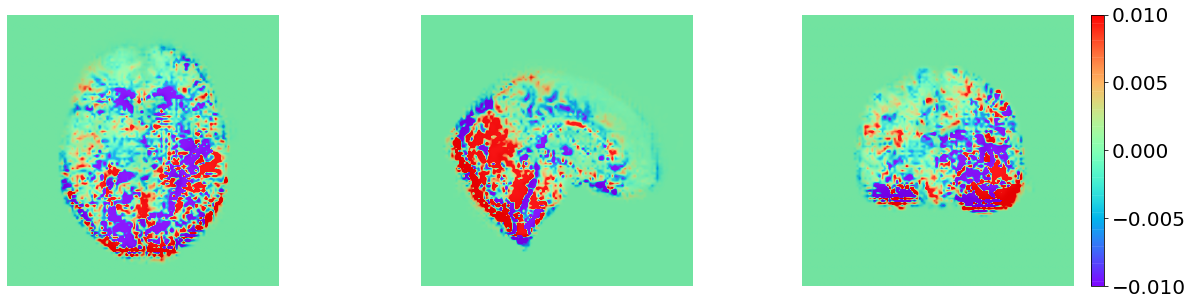

Vox16
81 [[0.5332632  0.46673673]] 0
Shap


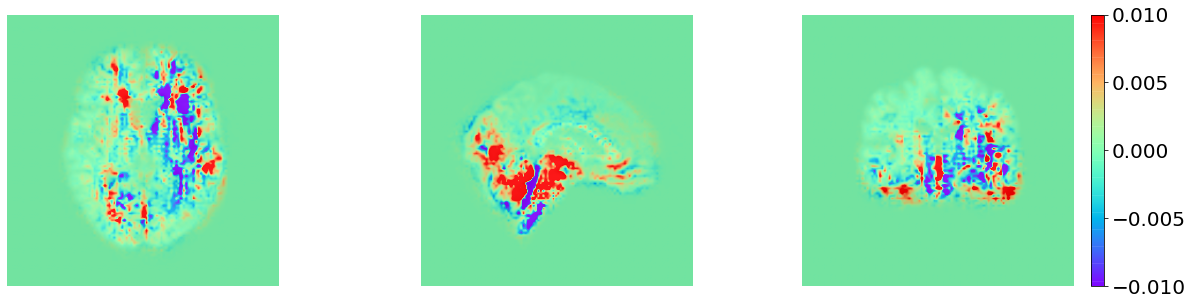

Org Paper
81 [[0.36138386 0.63861614]] 0
Shap


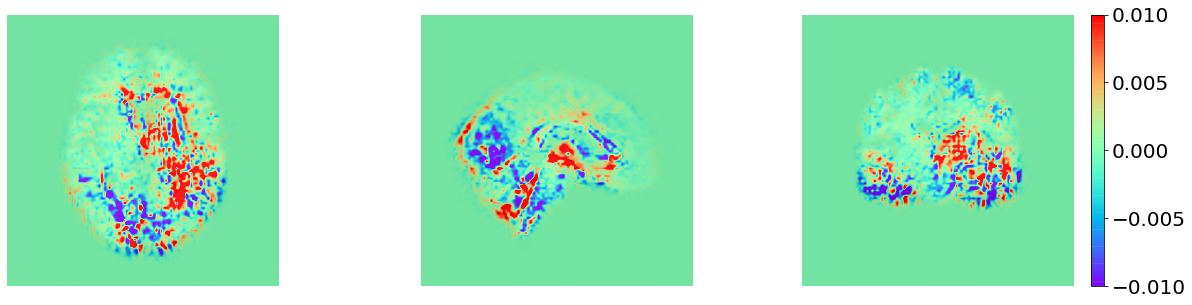

In [57]:
if (True):

    b3DUCM = False
    bCAM = False
    bShap = True
    bOcc = False
  
    for nData in [81]: #(3,26,39,42,45,53,55,81,90,99)
        print ("MRI No:  ", nData)
        
        print ("Attention")
        PrintResults (nData,"noneADCNAttention_20200801-023626_results.npz",  "V5", "noneADCNAttention_20200731-235716_bestW.hdf5","att",bOcc, b3DUCM, bCAM, bShap)
        print("Vox16")
        PrintResults (nData, "noneADCNKorolev_20200723-131526_results.npz",  "V3", "noneADCNKorolev_20200723-104400_bestW.hdf5", "Vox16",bOcc, b3DUCM, bCAM, bShap)
        print("Org Paper")
        PrintResultsOrg (nData, "noneADCNKorolev_20200723-081701_results.npz",  "V3", "noneADCNKorolev_20200723-063922_bestW.hdf5","org",bOcc, b3DUCM, bCAM, bShap)
    
    


  0%|          | 0/19 [00:00<?, ?it/s]

3 [[0.8915568  0.10844317]] 0
3DUCM


100%|██████████| 19/19 [01:20<00:00,  4.23s/it]


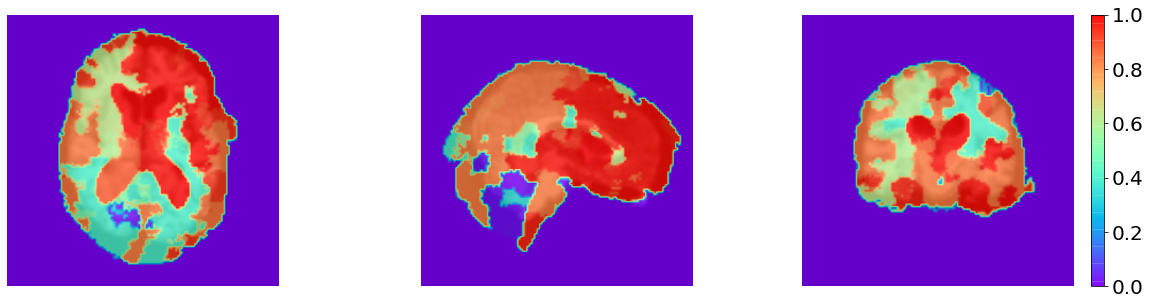

CAM 1st conv.


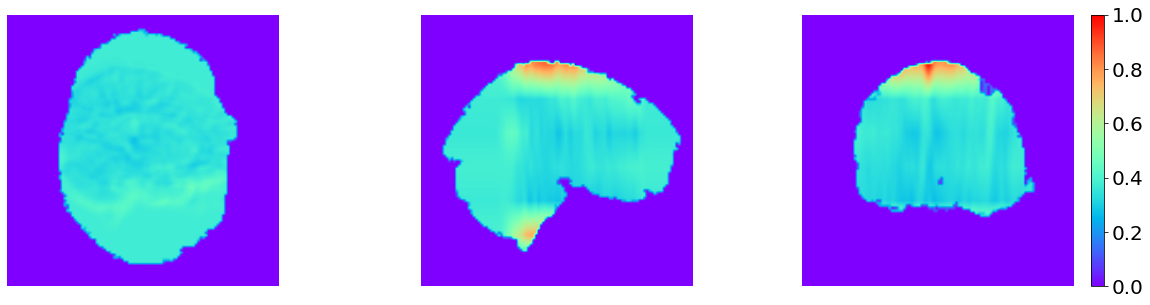

CAM last conv.


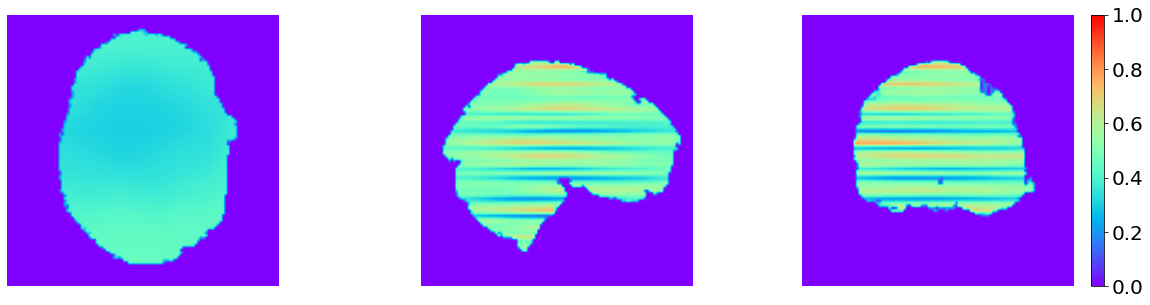

Shap


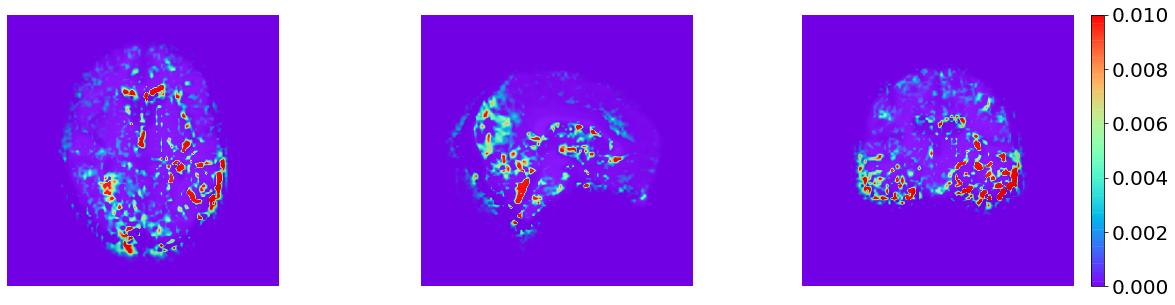

In [79]:
PrintResultsOrg (3, "noneADCNKorolev_20200723-081701_results.npz",  "V3", "noneADCNKorolev_20200723-063922_bestW.hdf5",b3DUCM, bCAM, bShap)



Tensor("global_average_pooling3d/Identity:0", shape=(None, 128), dtype=float32)
Tensor("ExpandDims_1:0", shape=(None, 6, 6, 6, 1), dtype=float32)
Tensor("mul:0", shape=(None, 6, 6, 6, 128), dtype=float32)


  0%|          | 0/19 [00:00<?, ?it/s]

3DUCM


100%|██████████| 19/19 [01:45<00:00,  5.54s/it]


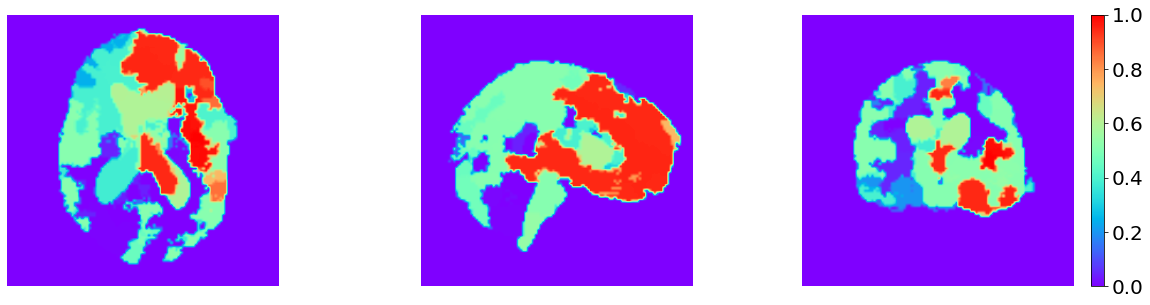

CAM 1st conv.


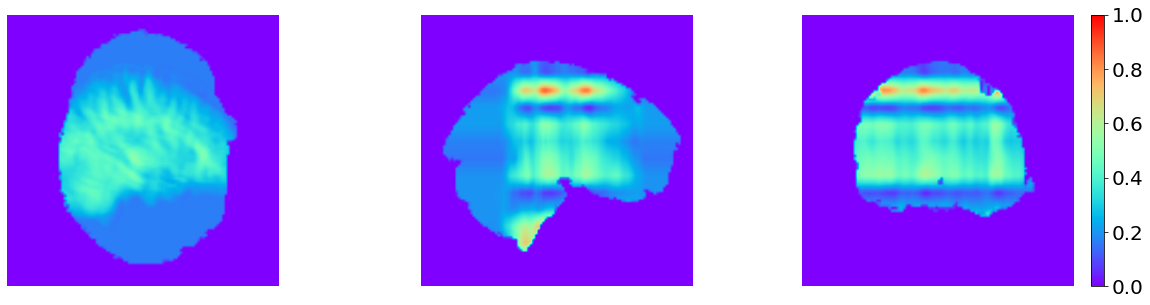

CAM last conv.


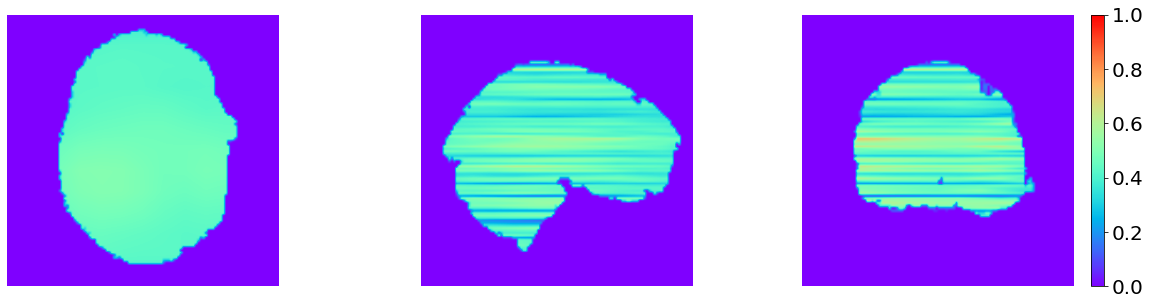

Shap


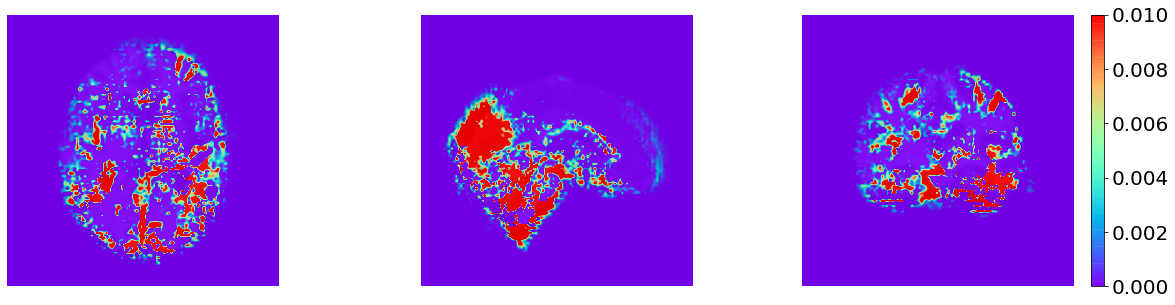

Tensor("global_average_pooling3d/Identity:0", shape=(None, 128), dtype=float32)
Tensor("ExpandDims_1:0", shape=(None, 6, 6, 6, 1), dtype=float32)
Tensor("mul:0", shape=(None, 6, 6, 6, 128), dtype=float32)


  0%|          | 0/19 [00:00<?, ?it/s]

3DUCM


100%|██████████| 19/19 [01:45<00:00,  5.56s/it]


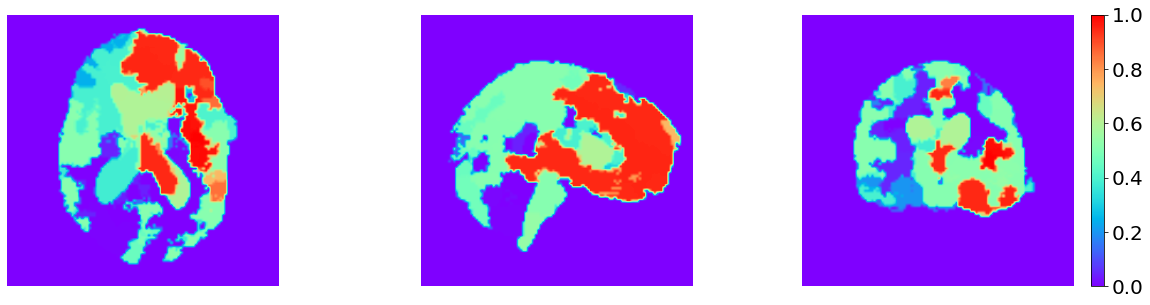

CAM 1st conv.


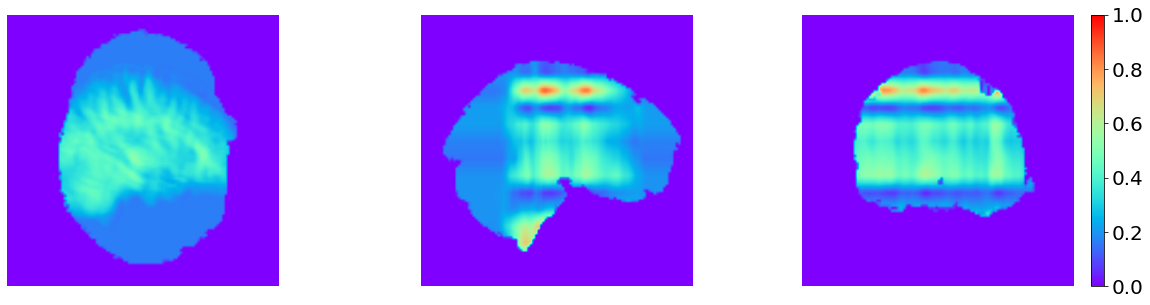

CAM last conv.


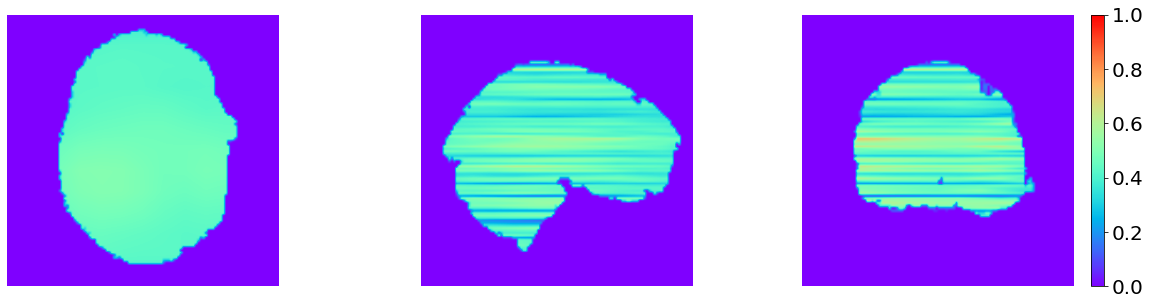

Shap


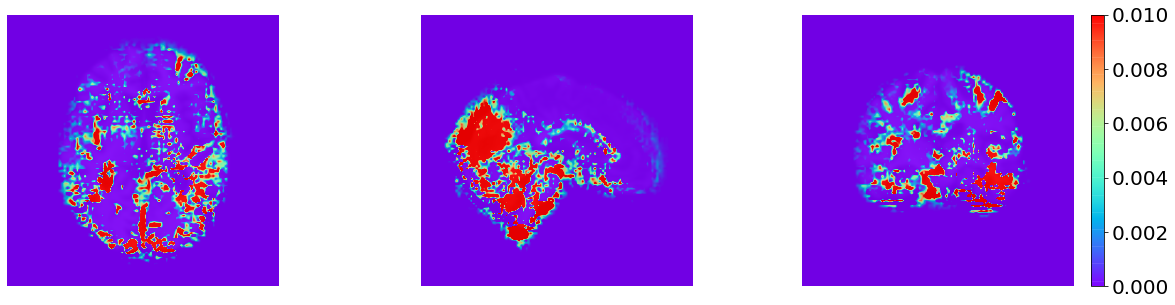

Tensor("global_average_pooling3d/Identity:0", shape=(None, 128), dtype=float32)
Tensor("ExpandDims_1:0", shape=(None, 6, 6, 6, 1), dtype=float32)
Tensor("mul:0", shape=(None, 6, 6, 6, 128), dtype=float32)


  0%|          | 0/19 [00:00<?, ?it/s]

3DUCM


100%|██████████| 19/19 [01:45<00:00,  5.57s/it]


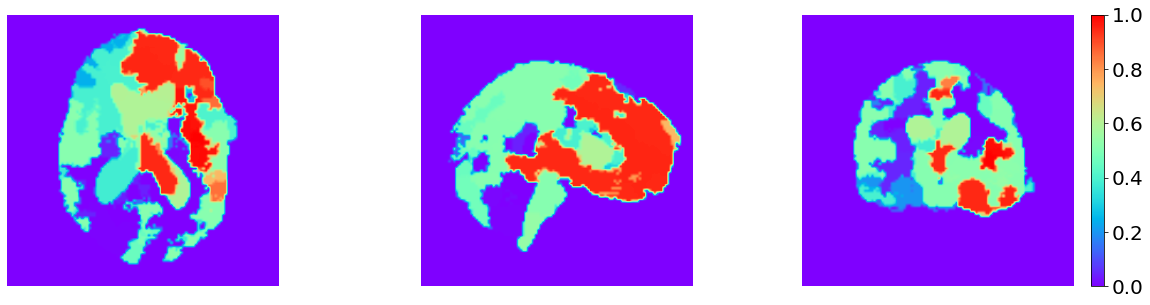

CAM 1st conv.


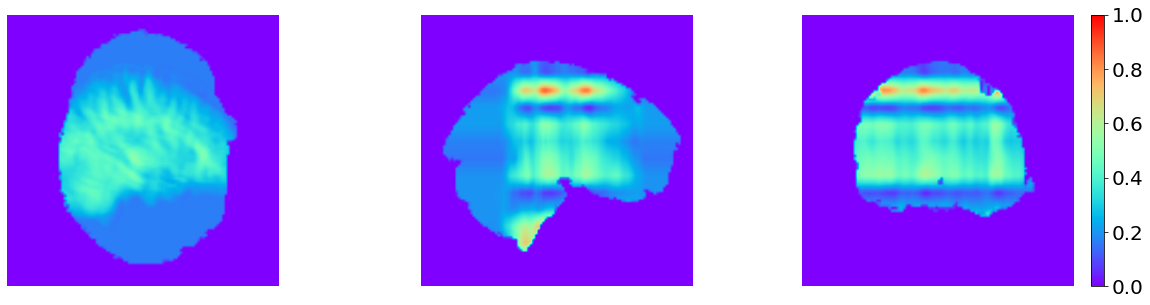

CAM last conv.


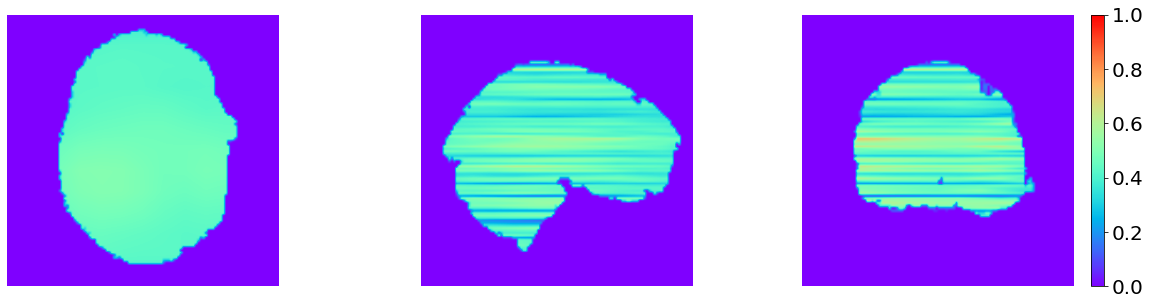

Shap


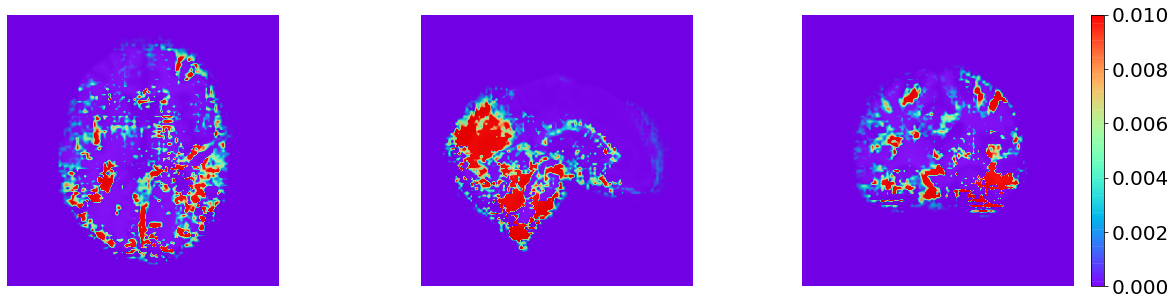

In [223]:
if (False):
    mri = data[111][0]
    mri_rz = resize(mri,(256,256,256))   


    PrintResults ("noneADCNAttention_20200801-023626_results.npz",  "V5", "noneADCNAttention_20200731-235716_bestW.hdf5", mri)
    PrintResults ("noneADCNKorolev_20200723-131526_results.npz",  "V3", "noneADCNKorolev_20200723-104400_bestW.hdf5", mri)
    PrintResults ("noneADCNKorolev_20200723-081701_results.npz",  "V3", "noneADCNKorolev_20200723-063922_bestW.hdf5", mri)
    
    


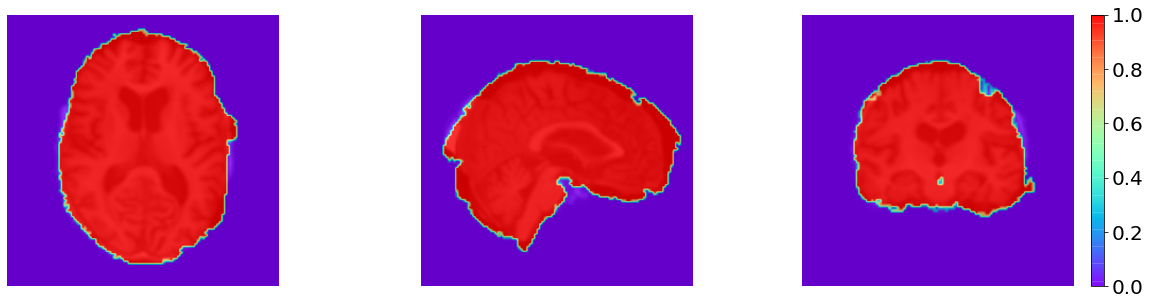

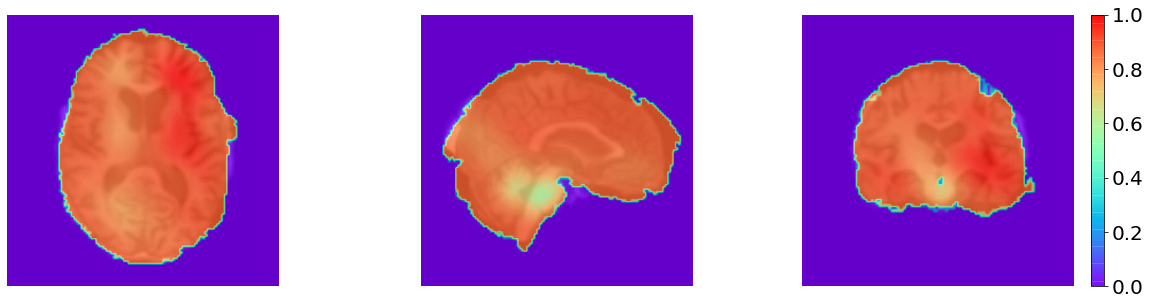

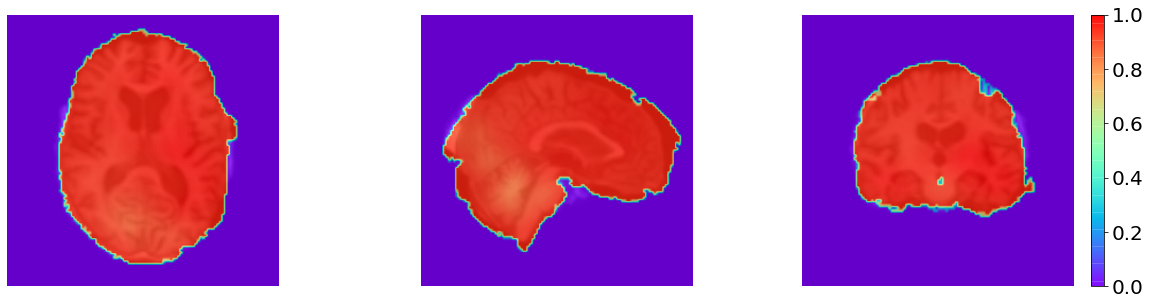

In [92]:
mri = data[53][0]
mri_rz = resize(mri,(256,256,256))
thres = 0.99
res_oc_att = np.load("occ_att53_AD.npy")
res_oc_Vox16 = np.load("occ_vox1653_AD.npy")
res_oc_org = np.load("occ_org53_AD.npy")
oc_att = copy.deepcopy(res_oc_att[:,:,:,0])
oc_Vox16 = copy.deepcopy(res_oc_Vox16[:,:,:,0])
oc_org = copy.deepcopy(res_oc_org[:,:,:,0])
Print3Occ(oc_att,thres)
Print3Occ(oc_Vox16,thres)
Print3Occ(oc_org,thres)
